In [ ]:
! pip install bertopic nltk

In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

In [ ]:
news_data = pd.read_csv("./bbc-news-data.csv", sep="\t")
news_data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Data Preprocessing
- stopwords, alphabet이 아닌 word 제거
- 길이가 3 이하인 단어 제거
- 빈도수가 낮은 word 제거 (제거 기준: 5개 이하)
- 소문자 변환
- `vocab_to_index`, `index_to_vocab` dictionary 정의
- text data를 index로 변환

In [ ]:
news_df = pd.DataFrame({'document': news_data["content"]})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ", regex=True)

# 길이가 3 이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

# stopwords 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 불용어 제거
nltk.download('stopwords')
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = []

for i in range(tokenized_doc.shape[0]): # document 개수
  doc = tokenized_doc[i]
  data.append(doc)

len(data)

2225

In [ ]:
# count word occurrence in corpus
def count_vocab(corpus):
    vocab = defaultdict(int)
    for doc in corpus:
        for word in doc:
            vocab[word] += 1

    return vocab

vocab_count = count_vocab(data)


# only consider valid words with occurrence > cnt
def vocab_top(vocab,cnt):
    temp = defaultdict(int)
    for voca, count in vocab.items():
        if count > cnt:
            temp[voca] = count

    return temp

vocab_count = vocab_top(vocab_count, cnt=5)


# filter out low-occurrence words
def filter_vocab(corpus,vocab):
    data = list()
    for doc in corpus:
        temp = list()
        for word in doc:
            if word in vocab.keys():
                temp.append(word)
        if temp:
            data.append(temp)

    return data

data = filter_vocab(data, vocab_count)

In [ ]:
# construct voca-index-matching dictionary
def voca_index(vocab):
    vocab_to_index, index_to_vocab = dict(), dict()
    for i, voca in enumerate(vocab.keys()):
        vocab_to_index[voca] = i
        index_to_vocab[i] = voca

    return vocab_to_index, index_to_vocab

v_t_i, i_t_v = voca_index(vocab_count)


# convert corpus-with-words to corpus-with-index
def corpus_to_index(corpus,vocab_to_index):
    data = list()
    for doc in corpus:
        temp = list()
        for word in doc:
            temp.append(vocab_to_index[word])
        data.append(temp)

    return data

data_idx = corpus_to_index(data, v_t_i)

In [ ]:
docs = [' '.join(words) for words in data]
len(docs)

2225

## LDA

In [ ]:
class LDA_VI:
    def __init__(self, docs, vocab, num_topic=10, num_iter=100):
        self.docs = docs # corpus: M개의 documents
        self.num_topic = num_topic # K: topic의 개수
        self.vocab = vocab # v_t_i / i_t_v
        self.num_vocab = len(self.vocab) # V: corpus에 존재하는 vocab의 개수
        self.num_docs = len(self.docs) # M: document의 개수

        self.alpha = np.ones(self.num_topic)*(1/self.num_topic) # K-vector

        self.beta = np.ones((self.num_topic,self.num_vocab))*(1/self.num_vocab) # K x V


        self.eps = 1e-12

        # beta random initialization
        for i in range(self.num_topic):
            for v in range(self.num_vocab):
                self.beta[i][v] += np.random.rand(1) * 0.01
            # 각 topic에 대해 beta normailize
            self.beta[i] /= np.sum(self.beta[i])

        self.gamma = np.ones((self.num_docs,self.num_topic))*(1/self.num_topic) # M x K

        self.phi = list() # M x Nd x K
        for doc in self.docs:
            temp = list()
            for word in doc:
                temp.append(np.ones(self.num_topic)*(1/self.num_topic))
            self.phi.append(temp)

        self.z = list() # M x Nd
        for doc in self.docs:
            temp = list()
            for word in doc:
                temp.append(None)
            self.z.append(temp)

        self.num_iter = num_iter # Variational EM 반복 횟수

        self.perps = [float("inf")] # iter별 perplexity


    def update_gamma(self, m): # m번째 document에 대해서 gamma update
        # gamma[m, i]: m번째 document에서 i번째 topic에 대한 Dirichlet 파라미터

        for i in range(self.num_topic):
            self.gamma[m, i] = self.alpha[i]
            for n in range(len(self.docs[m])):
                self.gamma[m, i] += self.phi[m][n][i]
        return None


    def update_phi(self, m): # m번째 document에 대해 phi update
        # phi[m, n, i]: m번째 document의 n번째 word가 i번째 topic일 확률

        for n in range(len(self.docs[m])):
            for i in range(self.num_topic):
                self.phi[m][n][i] = self.beta[i, self.docs[m][n]] * np.exp(digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m]))) + 1e-10

            # 각 vocab에 대해 phi normailize
            self.phi[m][n] /= np.sum(self.phi[m][n])
        return None


    def update_beta(self): #corpus에 대해 beta update
        # beta[i, v]: topic이 i일때, v번째 word가 나타날 확률

        self.beta = np.zeros((self.num_topic,self.num_vocab)) #beta 초기화

        for m in range(self.num_docs):
            for n in range(len(self.docs[m])):
                for i in range(self.num_topic):
                    self.beta[i, self.docs[m][n]] += self.phi[m][n][i]

        # 각 topic에 대해 beta normailize
        for i in range(self.num_topic):
            self.beta[i] += 1e-10
            self.beta[i] /= np.sum(self.beta[i])
        return None


    def update_alpha(self): # corpus에 대해 alpha update
        # alpha[i]: i번째 topic에 대한 Dirichlet 파라미터

        # compute g
        g = np.zeros(self.num_topic) # elbo의 1차 미분

        for i in range(self.num_topic):
            g[i] = self.num_docs * ( digamma(np.sum(self.alpha)) - digamma(self.alpha[i]) )
            for m in range(self.num_docs):
                g[i] += ( digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])) )

        # compute H
        H = np.zeros((self.num_topic, self.num_topic)) # elbo의 2차 미분

        for i in range(self.num_topic):
            for j in range(self.num_topic):
                if i == j:
                    H[i, j] = -self.num_docs * polygamma(1, self.alpha[i]) + self.num_docs * polygamma(1, np.sum(self.alpha))
                else:
                    H[i, j] = self.num_docs * polygamma(1, np.sum(self.alpha))

        self.alpha -= np.linalg.inv(H) @ g
        return None

    def update_alpha_linear_time(self):
        # compute g
        g = np.zeros(self.num_topic)

        for i in range(self.num_topic):
            g[i] = self.num_docs * (digamma(self.alpha.sum()) - digamma(self.alpha[i]))
            for m in range(self.num_docs):
                g[i] += (digamma(self.gamma[m, i]) - digamma(self.gamma[m].sum()))

        # compute h
        h = np.zeros(self.num_topic)
        for i in range(self.num_topic):
            h[i] =  -self.num_docs * polygamma(1,self.alpha[i])

        z = self.num_docs * polygamma(1, self.alpha.sum())

        c = (g/h).sum()/ (1/z + (1/h).sum())

        self.alpha -= ((g-c) / h)
        return None


    def e_step(self):
        # document별 phi, gamma update
        for m in range(self.num_docs):
            self.update_phi(m)
            self.update_gamma(m)
        return None


    def m_step(self):
        self.update_beta() # beta update

        # alpha update
        for iter in range(5):
            self.update_alpha_linear_time()
        return None


    def compute_elbo(self, m):
        elbo = 0

        for i in range(self.num_topic):
            for n in range(len(self.docs[m])):
                elbo += ( self.phi[m][n][i] * (np.log(self.beta[i, self.docs[m][n]])
                                                + (digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])))
                                                - np.log(self.phi[m][n][i])) )

            elbo += ( (self.alpha[i] - self.gamma[m, i]) * (digamma(self.gamma[m, i]) - digamma(np.sum(self.gamma[m])))
                    - gammaln(self.alpha[i])
                    + gammaln(self.gamma[m, i]))

        elbo += ( gammaln(np.sum(self.alpha)) - gammaln(np.sum(self.gamma[m])))
        return elbo


    def compute_perplexity(self,):
        total_elbo = 0
        total_N = 0

        for m in range(self.num_docs):
            total_elbo += self.compute_elbo(m)
            total_N += len(self.docs[m])

        perplexity = np.exp(-total_elbo / total_N)
        return perplexity


    def compute_z(self):
        # z[m][n]: m번째 document에서 n번째 word의 topic

        for m in range(self.num_docs):
            for n in range(len(self.docs[m])):
                self.z[m][n] = np.random.multinomial(1, self.phi[m][n]).argmax().item()
        return None


    def run(self,):
        cnt = 0

        for iter in range(self.num_iter):
            # variational EM
            self.e_step()
            self.m_step()

            perplexity = self.compute_perplexity()
            self.perps.append(perplexity)
            print(f"\n[#{iter+1}] perplexity: {perplexity:.5f}")

            # 종료 조건
            if (self.perps[-2] - self.perps[-1]) < 1:
                cnt += 1

            if cnt > 5:
                break

        self.compute_z()
        return None

In [ ]:
# 모델 불러오기
with open("LDA_model.pkl", "rb") as f:
    LDA = pickle.load(f)

# 확인
print(LDA.alpha)
print(LDA.beta.shape)

[0.04734795 0.04279643 0.06338374 0.06035623 0.05132568]
(5, 8664)


In [ ]:
# LDA Document - Topic proportion
theta_values = [np.random.dirichlet(gamma) for gamma in LDA.gamma]

In [ ]:
def topic_word(model, topic, num_words=10): # 각 topic별 나올 확률이 높은 10개의 words
    words = [i_t_v[index] for index in model.beta[topic].argsort()[::-1][:num_words]]
    return words

LDA_topic_word = [topic_word(LDA, i) for i in range(LDA.num_topic)]
print(LDA_topic_word)

[['said', 'game', 'first', 'year', 'time', 'england', 'world', 'last', 'back', 'play'], ['film', 'best', 'said', 'year', 'music', 'also', 'show', 'awards', 'first', 'award'], ['said', 'would', 'government', 'labour', 'people', 'election', 'party', 'blair', 'also', 'minister'], ['said', 'year', 'market', 'also', 'growth', 'sales', 'would', 'last', 'economy', 'company'], ['said', 'people', 'mobile', 'technology', 'also', 'could', 'users', 'would', 'phone', 'many']]


# BERTopic

In [ ]:
# Embeddings
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2")

In [ ]:
# Dimensionality Reduction
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
# Clustering
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=2, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Our method (LDA + BERTopic)

In [ ]:
import yaml
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

try:
    yaml._warnings_enabled["YAMLLoadWarning"] = False
except (KeyError, AttributeError, TypeError):
    pass

import re
import math
import joblib
import inspect
import collections
import numpy as np
import pandas as pd
import scipy.sparse as sp
from copy import deepcopy

from tqdm import tqdm
from pathlib import Path
from packaging import version
from tempfile import TemporaryDirectory
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
from scipy.cluster import hierarchy as sch
from importlib.util import find_spec

from typing import List, Tuple, Union, Mapping, Any, Callable, Iterable, TYPE_CHECKING, Literal

# Plotting
if find_spec("plotly") is None:
    from bertopic._utils import MockPlotlyModule

    plotting = MockPlotlyModule()

else:
    from bertopic import plotting

    if TYPE_CHECKING:
        import plotly.graph_objs as go
        import matplotlib.figure as fig


# Models
try:
    from hdbscan import HDBSCAN

    HAS_HDBSCAN = True
except (ImportError, ModuleNotFoundError):
    HAS_HDBSCAN = False
    from sklearn.cluster import HDBSCAN as SK_HDBSCAN

from sklearn.preprocessing import normalize
from sklearn import __version__ as sklearn_version
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# BERTopic
from bertopic.cluster import BaseCluster
from bertopic.backend import BaseEmbedder
from bertopic.representation._mmr import mmr
from bertopic.backend._utils import select_backend
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import BaseRepresentation, KeyBERTInspired
from bertopic.dimensionality import BaseDimensionalityReduction
from bertopic.cluster._utils import hdbscan_delegator, is_supported_hdbscan
from bertopic._utils import (
    MyLogger,
    check_documents_type,
    check_embeddings_shape,
    check_is_fitted,
    validate_distance_matrix,
    select_topic_representation,
    get_unique_distances,
)
import bertopic._save_utils as save_utils

logger = MyLogger()
logger.configure("WARNING")


class BERTopic:
    """BERTopic is a topic modeling technique that leverages BERT embeddings and
    c-TF-IDF to create dense clusters allowing for easily interpretable topics
    whilst keeping important words in the topic descriptions.

    The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"`
    and `paraphrase-multilingual-MiniLM-L12-v2` when selecting `language="multilingual"`.

    Attributes:
        topics_ (List[int]) : The topics that are generated for each document after training or updating
                              the topic model. The most recent topics are tracked.
        probabilities_ (List[float]): The probability of the assigned topic per document. These are
                                      only calculated if a HDBSCAN model is used for the clustering step.
                                      When `calculate_probabilities=True`, then it is the probabilities
                                      of all topics per document.
        topic_sizes_ (Mapping[int, int]) : The size of each topic.
        topic_mapper_ (TopicMapper) : A class for tracking topics and their mappings anytime they are
                                      merged, reduced, added, or removed.
        topic_representations_ (Mapping[int, Tuple[int, float]]) : The top n terms per topic and their respective
                                                                   c-TF-IDF values.
        c_tf_idf_ (csr_matrix) : The topic-term matrix as calculated through c-TF-IDF. To access its respective
                                 words, run `.vectorizer_model.get_feature_names()`  or
                                 `.vectorizer_model.get_feature_names_out()`
        topic_labels_ (Mapping[int, str]) : The default labels for each topic.
        custom_labels_ (List[str]) : Custom labels for each topic.
        topic_embeddings_ (np.ndarray) : The embeddings for each topic. They are calculated by taking the
                                         centroid embedding of each cluster.
        representative_docs_ (Mapping[int, str]) : The representative documents for each topic.

    Examples:
    ```python
    from bertopic import BERTopic
    from sklearn.datasets import fetch_20newsgroups

    docs = fetch_20newsgroups(subset='all')['data']
    topic_model = BERTopic()
    topics, probabilities = topic_model.fit_transform(docs)
    ```

    If you want to use your own embedding model, use it as follows:

    ```python
    from bertopic import BERTopic
    from sklearn.datasets import fetch_20newsgroups
    from sentence_transformers import SentenceTransformer

    docs = fetch_20newsgroups(subset='all')['data']
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    topic_model = BERTopic(embedding_model=sentence_model)
    ```

    Due to the stochastic nature of UMAP, the results from BERTopic might differ
    and the quality can degrade. Using your own embeddings allows you to
    try out BERTopic several times until you find the topics that suit
    you best.
    """

    def __init__(
        self,
        language: str = "english",
        top_n_words: int = 10,
        n_gram_range: Tuple[int, int] = (1, 1),
        min_topic_size: int = 10,
        nr_topics: Union[int, str] = None,
        low_memory: bool = False,
        calculate_probabilities: bool = False,
        seed_topic_list: List[List[str]] = None,
        zeroshot_topic_list: List[str] = None,
        zeroshot_min_similarity: float = 0.7,
        embedding_model=None,
        umap_model=None,
        hdbscan_model=None,
        vectorizer_model: CountVectorizer = None,
        ctfidf_model: TfidfTransformer = None,
        representation_model: BaseRepresentation = None,
        verbose: bool = False,
        alpha=0.75
    ):
        """BERTopic initialization.

        Arguments:
            language: The main language used in your documents. The default sentence-transformers
                      model for "english" is `all-MiniLM-L6-v2`. For a full overview of
                      supported languages see bertopic.backend.languages. Select
                      "multilingual" to load in the `paraphrase-multilingual-MiniLM-L12-v2`
                      sentence-transformers model that supports 50+ languages.
                      NOTE: This is not used if `embedding_model` is used.
            top_n_words: The number of words per topic to extract. Setting this
                         too high can negatively impact topic embeddings as topics
                         are typically best represented by at most 10 words.
            n_gram_range: The n-gram range for the CountVectorizer.
                          Advised to keep high values between 1 and 3.
                          More would likely lead to memory issues.
                          NOTE: This param will not be used if you pass in your own
                          CountVectorizer.
            min_topic_size: The minimum size of the topic. Increasing this value will lead
                            to a lower number of clusters/topics and vice versa.
                            It is the same parameter as `min_cluster_size` in HDBSCAN.
                            NOTE: This param will not be used if you are using `hdbscan_model`.
            nr_topics: Specifying the number of topics will reduce the initial
                       number of topics to the value specified. This reduction can take
                       a while as each reduction in topics (-1) activates a c-TF-IDF
                       calculation. If this is set to None, no reduction is applied. Use
                       "auto" to automatically reduce topics using HDBSCAN.
                       NOTE: Controlling the number of topics is best done by adjusting
                       `min_topic_size` first before adjusting this parameter.
            low_memory: Sets UMAP low memory to True to make sure less memory is used.
                        NOTE: This is only used in UMAP. For example, if you use PCA instead of UMAP
                        this parameter will not be used.
            calculate_probabilities: Calculate the probabilities of all topics
                                     per document instead of the probability of the assigned
                                     topic per document. This could slow down the extraction
                                     of topics if you have many documents (> 100_000).
                                     NOTE: If false you cannot use the corresponding
                                     visualization method `visualize_probabilities`.
                                     NOTE: This is an approximation of topic probabilities
                                     as used in HDBSCAN and not an exact representation.
            seed_topic_list: A list of seed words per topic to converge around
            zeroshot_topic_list: A list of topic names to use for zero-shot classification
            zeroshot_min_similarity: The minimum similarity between a zero-shot topic and
                                     a document for assignment. The higher this value, the more
                                     confident the model needs to be to assign a zero-shot topic to a document.
            verbose: Changes the verbosity of the model, Set to True if you want
                     to track the stages of the model.
            embedding_model: Use a custom embedding model.
                             The following backends are currently supported
                               * SentenceTransformers
                               * Flair
                               * Spacy
                               * Gensim
                               * USE (TF-Hub)
                             You can also pass in a string that points to one of the following
                             sentence-transformers models:
                               * https://www.sbert.net/docs/pretrained_models.html
            umap_model: Pass in a UMAP model to be used instead of the default.
                        NOTE: You can also pass in any dimensionality reduction algorithm as long
                        as it has `.fit` and `.transform` functions.
            hdbscan_model: Pass in a hdbscan.HDBSCAN model to be used instead of the default
                           NOTE: You can also pass in any clustering algorithm as long as it has
                           `.fit` and `.predict` functions along with the `.labels_` variable.
            vectorizer_model: Pass in a custom `CountVectorizer` instead of the default model.
            ctfidf_model: Pass in a custom ClassTfidfTransformer instead of the default model.
            representation_model: Pass in a model that fine-tunes the topic representations
                                  calculated through c-TF-IDF. Models from `bertopic.representation`
                                  are supported.
        """
        # Topic-based parameters
        if top_n_words > 100:
            logger.warning(
                "Note that extracting more than 100 words from a sparse can slow down computation quite a bit."
            )

        self.top_n_words = top_n_words
        self.min_topic_size = min_topic_size
        self.nr_topics = nr_topics
        self.low_memory = low_memory
        self.calculate_probabilities = calculate_probabilities
        self.verbose = verbose
        self.seed_topic_list = seed_topic_list
        self.zeroshot_topic_list = zeroshot_topic_list
        self.zeroshot_min_similarity = zeroshot_min_similarity

        # Embedding model
        self.language = language if not embedding_model else None
        self.embedding_model = embedding_model

        # Vectorizer
        self.n_gram_range = n_gram_range
        self.vectorizer_model = vectorizer_model or CountVectorizer(ngram_range=self.n_gram_range)
        self.ctfidf_model = ctfidf_model or ClassTfidfTransformer()

        # Representation model
        self.representation_model = representation_model

        # UMAP or another algorithm that has .fit and .transform functions
        if umap_model is not None:
            self.umap_model = umap_model
        else:
            try:
                from umap import UMAP

                self.umap_model = UMAP(
                    n_neighbors=15,
                    n_components=5,
                    min_dist=0.0,
                    metric="cosine",
                    low_memory=self.low_memory,
                )
            except (ImportError, ModuleNotFoundError):
                self.umap_model = PCA(n_components=5)

        # HDBSCAN or another clustering algorithm that has .fit and .predict functions and
        # the .labels_ variable to extract the labels

        if hdbscan_model is not None:
            self.hdbscan_model = hdbscan_model
        elif HAS_HDBSCAN:
            self.hdbscan_model = HDBSCAN(
                min_cluster_size=self.min_topic_size,
                metric="euclidean",
                cluster_selection_method="eom",
                prediction_data=True,
            )
        else:
            self.hdbscan_model = SK_HDBSCAN(
                min_cluster_size=self.min_topic_size, metric="euclidean", cluster_selection_method="eom", n_jobs=-1
            )

        # Public attributes
        self.topics_ = None
        self.probabilities_ = None
        self.topic_sizes_ = None
        self.topic_mapper_ = None
        self.topic_representations_ = None
        self.topic_embeddings_ = None
        self._topic_id_to_zeroshot_topic_idx = {}
        self.custom_labels_ = None
        self.c_tf_idf_ = None
        self.representative_images_ = None
        self.representative_docs_ = {}
        self.topic_aspects_ = {}

        # Private attributes for internal tracking purposes
        self._merged_topics = None

        if verbose:
            logger.set_level("DEBUG")
        else:
            logger.set_level("WARNING")

        self.alpha = alpha # Hybrid scale

    @property
    def _outliers(self):
        """Some algorithms have outlier labels (-1) that can be tricky to work
        with if you are slicing data based on that labels. Therefore, we
        track if there are outlier labels and act accordingly when slicing.

        Returns:
            An integer indicating whether outliers are present in the topic model
        """
        return 1 if -1 in self.topic_sizes_ else 0

    @property
    def topic_labels_(self):
        """Map topic IDs to their labels.
        A label is the topic ID, along with the first four words of the topic representation, joined using '_'.
        Zeroshot topic labels come from self.zeroshot_topic_list rather than the calculated representation.

        Returns:
            topic_labels: a dict mapping a topic ID (int) to its label (str)
        """
        topic_labels = {
            key: f"{key}_" + "_".join([word[0] for word in values[:4]])
            for key, values in self.topic_representations_.items()
        }
        if self._is_zeroshot():
            # Need to correct labels from zero-shot topics
            topic_id_to_zeroshot_label = {
                topic_id: self.zeroshot_topic_list[zeroshot_topic_idx]
                for topic_id, zeroshot_topic_idx in self._topic_id_to_zeroshot_topic_idx.items()
            }
            topic_labels.update(topic_id_to_zeroshot_label)
        return topic_labels

    def fit(
        self,
        documents: List[str],
        embeddings: np.ndarray = None,
        images: List[str] = None,
        y: Union[List[int], np.ndarray] = None,
    ):
        """Fit the models on a collection of documents and generate topics.

        Arguments:
            documents: A list of documents to fit on
            embeddings: Pre-trained document embeddings. These can be used
                        instead of the sentence-transformer model
            images: A list of paths to the images to fit on or the images themselves
            y: The target class for (semi)-supervised modeling. Use -1 if no class for a
               specific instance is specified.

        Examples:
        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups

        docs = fetch_20newsgroups(subset='all')['data']
        topic_model = BERTopic().fit(docs)
        ```

        If you want to use your own embeddings, use it as follows:

        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer

        # Create embeddings
        docs = fetch_20newsgroups(subset='all')['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=True)

        # Create topic model
        topic_model = BERTopic().fit(docs, embeddings)
        ```
        """
        self.fit_transform(documents=documents, embeddings=embeddings, y=y, images=images)
        return self

    def fit_transform(
        self,
        documents: List[str],
        embeddings: np.ndarray = None,
        images: List[str] = None,
        y: Union[List[int], np.ndarray] = None,
    ) -> Tuple[List[int], Union[np.ndarray, None]]:
        """Fit the models on a collection of documents, generate topics,
        and return the probabilities and topic per document.

        Arguments:
            documents: A list of documents to fit on
            embeddings: Pre-trained document embeddings. These can be used
                        instead of the sentence-transformer model
            images: A list of paths to the images to fit on or the images themselves
            y: The target class for (semi)-supervised modeling. Use -1 if no class for a
               specific instance is specified.

        Returns:
            predictions: Topic predictions for each documents
            probabilities: The probability of the assigned topic per document.
                           If `calculate_probabilities` in BERTopic is set to True, then
                           it calculates the probabilities of all topics across all documents
                           instead of only the assigned topic. This, however, slows down
                           computation and may increase memory usage.

        Examples:
        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups

        docs = fetch_20newsgroups(subset='all')['data']
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)
        ```

        If you want to use your own embeddings, use it as follows:

        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer

        # Create embeddings
        docs = fetch_20newsgroups(subset='all')['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=True)

        # Create topic model
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs, embeddings)
        ```
        """
        if documents is not None:
            check_documents_type(documents)
            check_embeddings_shape(embeddings, documents)

        doc_ids = range(len(documents)) if documents is not None else range(len(images))
        documents = pd.DataFrame({"Document": documents, "ID": doc_ids, "Topic": None, "Image": images})

        # Extract embeddings
        if embeddings is None:
            logger.info("Embedding - Transforming documents to embeddings.")
            self.embedding_model = select_backend(self.embedding_model, language=self.language, verbose=self.verbose)
            embeddings = self._extract_embeddings(
                documents.Document.values.tolist(),
                images=images,
                method="document",
                verbose=self.verbose,
            )
            logger.info("Embedding - Completed \u2713")
        else:
            if self.embedding_model is not None:
                self.embedding_model = select_backend(
                    self.embedding_model, language=self.language, verbose=self.verbose
                )

        # Guided Topic Modeling
        if self.seed_topic_list is not None and self.embedding_model is not None:
            y, embeddings = self._guided_topic_modeling(embeddings)

        # Reduce dimensionality and fit UMAP model
        umap_embeddings = self._reduce_dimensionality(embeddings, y)

        # Zero-shot Topic Modeling
        if self._is_zeroshot():
            documents, embeddings, assigned_documents, assigned_embeddings = self._zeroshot_topic_modeling(
                documents, embeddings
            )

            # Filter UMAP embeddings to only non-assigned embeddings to be used for clustering
            if len(documents) > 0:
                umap_embeddings = self.umap_model.transform(embeddings)

        if len(documents) > 0:
            # Cluster reduced embeddings
            documents, probabilities = self._cluster_embeddings(umap_embeddings, documents, y=y)
            # print(f"topic 종류: {set(documents["Topic"])}")
            if self._is_zeroshot() and len(assigned_documents) > 0:
                documents, embeddings = self._combine_zeroshot_topics(
                    documents, embeddings, assigned_documents, assigned_embeddings
                )
        else:
            # All documents matches zero-shot topics
            documents = assigned_documents
            embeddings = assigned_embeddings

        # Sort and Map Topic IDs by their frequency
        if not self.nr_topics:
            documents = self._sort_mappings_by_frequency(documents)

        # Create documents from images if we have images only
        if documents.Document.values[0] is None:
            custom_documents = self._images_to_text(documents, embeddings)

            # Extract topics by calculating c-TF-IDF, reduce topics if needed, and get representations.
            self._extract_topics(custom_documents, embeddings=embeddings, fine_tune_representation=not self.nr_topics)
            if self.nr_topics:
                custom_documents = self._reduce_topics(custom_documents)
            self._create_topic_vectors(documents=documents, embeddings=embeddings)

            # Save the top 3 most representative documents per topic
            self._save_representative_docs(custom_documents)

        else:
            # Extract topics by calculating c-TF-IDF, reduce topics if needed, and get representations.
            self._extract_topics(
                documents, embeddings=embeddings, verbose=self.verbose, fine_tune_representation=not self.nr_topics
            )
            if self.nr_topics:
                documents = self._reduce_topics(documents)

            # Save the top 3 most representative documents per topic
            self._save_representative_docs(documents)

        # In the case of zero-shot topics, probability will come from cosine similarity,
        # and the HDBSCAN model will be removed
        if self._is_zeroshot() and len(assigned_documents) > 0:
            self.hdbscan_model = BaseCluster()
            sim_matrix = cosine_similarity(embeddings, np.array(self.topic_embeddings_))

            if self.calculate_probabilities:
                self.probabilities_ = sim_matrix
            else:
                self.probabilities_ = np.max(sim_matrix, axis=1)
        else:
            self.probabilities_ = self._map_probabilities(probabilities, original_topics=True)
        predictions = documents.Topic.to_list()

        return predictions, self.probabilities_

    def transform(
        self,
        documents: Union[str, List[str]],
        embeddings: np.ndarray = None,
        images: List[str] = None,
    ) -> Tuple[List[int], np.ndarray]:
        """After having fit a model, use transform to predict new instances.

        Arguments:
            documents: A single document or a list of documents to predict on
            embeddings: Pre-trained document embeddings. These can be used
                        instead of the sentence-transformer model.
            images: A list of paths to the images to predict on or the images themselves

        Returns:
            predictions: Topic predictions for each documents
            probabilities: The topic probability distribution which is returned by default.
                           If `calculate_probabilities` in BERTopic is set to False, then the
                           probabilities are not calculated to speed up computation and
                           decrease memory usage.

        Examples:
        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups

        docs = fetch_20newsgroups(subset='all')['data']
        topic_model = BERTopic().fit(docs)
        topics, probs = topic_model.transform(docs)
        ```

        If you want to use your own embeddings:

        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer

        # Create embeddings
        docs = fetch_20newsgroups(subset='all')['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=True)

        # Create topic model
        topic_model = BERTopic().fit(docs, embeddings)
        topics, probs = topic_model.transform(docs, embeddings)
        ```
        """
        check_is_fitted(self)
        check_embeddings_shape(embeddings, documents)

        if isinstance(documents, str) or documents is None:
            documents = [documents]

        if embeddings is None:
            embeddings = self._extract_embeddings(documents, images=images, method="document", verbose=self.verbose)

        # Check if an embedding model was found
        if embeddings is None:
            raise ValueError(
                "No embedding model was found to embed the documents."
                "Make sure when loading in the model using BERTopic.load()"
                "to also specify the embedding model."
            )

        # Transform without hdbscan_model and umap_model using only cosine similarity
        elif type(self.hdbscan_model) is BaseCluster:
            logger.info("Predicting topic assignments through cosine similarity of topic and document embeddings.")
            sim_matrix = cosine_similarity(embeddings, np.array(self.topic_embeddings_))
            predictions = np.argmax(sim_matrix, axis=1) - self._outliers

            if self.calculate_probabilities:
                probabilities = sim_matrix
            else:
                probabilities = np.max(sim_matrix, axis=1)

        # Transform with full pipeline
        else:
            logger.info("Dimensionality - Reducing dimensionality of input embeddings.")
            umap_embeddings = self.umap_model.transform(embeddings)
            logger.info("Dimensionality - Completed \u2713")

            # Extract predictions and probabilities if it is a HDBSCAN-like model
            logger.info("Clustering - Approximating new points with `hdbscan_model`")
            if is_supported_hdbscan(self.hdbscan_model):
                predictions, probabilities = hdbscan_delegator(
                    self.hdbscan_model, "approximate_predict", umap_embeddings
                )

                # Calculate probabilities
                if self.calculate_probabilities:
                    logger.info("Probabilities - Start calculation of probabilities with HDBSCAN")
                    probabilities = hdbscan_delegator(self.hdbscan_model, "membership_vector", umap_embeddings)
                    logger.info("Probabilities - Completed \u2713")
            else:
                predictions = self.hdbscan_model.predict(umap_embeddings)
                probabilities = None
            logger.info("Cluster - Completed \u2713")

            # Map probabilities and predictions
            probabilities = self._map_probabilities(probabilities, original_topics=True)
            predictions = self._map_predictions(predictions)
        return predictions, probabilities

    def partial_fit(
        self,
        documents: List[str],
        embeddings: np.ndarray = None,
        y: Union[List[int], np.ndarray] = None,
    ):
        """Fit BERTopic on a subset of the data and perform online learning
        with batch-like data.

        Online topic modeling in BERTopic is performed by using dimensionality
        reduction and cluster algorithms that support a `partial_fit` method
        in order to incrementally train the topic model.

        Likewise, the `bertopic.vectorizers.OnlineCountVectorizer` is used
        to dynamically update its vocabulary when presented with new data.
        It has several parameters for modeling decay and updating the
        representations.

        In other words, although the main algorithm stays the same, the training
        procedure now works as follows:

        For each subset of the data:

        1. Generate embeddings with a pre-trained language model
        2. Incrementally update the dimensionality reduction algorithm with `partial_fit`
        3. Incrementally update the cluster algorithm with `partial_fit`
        4. Incrementally update the OnlineCountVectorizer and apply some form of decay

        Note that it is advised to use `partial_fit` with batches and
        not single documents for the best performance.

        Arguments:
            documents: A list of documents to fit on
            embeddings: Pre-trained document embeddings. These can be used
                        instead of the sentence-transformer model
            y: The target class for (semi)-supervised modeling. Use -1 if no class for a
               specific instance is specified.

        Examples:
        ```python
        from sklearn.datasets import fetch_20newsgroups
        from sklearn.cluster import MiniBatchKMeans
        from sklearn.decomposition import IncrementalPCA
        from bertopic.vectorizers import OnlineCountVectorizer
        from bertopic import BERTopic

        # Prepare documents
        docs = fetch_20newsgroups(subset=subset,  remove=('headers', 'footers', 'quotes'))["data"]

        # Prepare sub-models that support online learning
        umap_model = IncrementalPCA(n_components=5)
        cluster_model = MiniBatchKMeans(n_clusters=50, random_state=0)
        vectorizer_model = OnlineCountVectorizer(stop_words="english", decay=.01)

        topic_model = BERTopic(umap_model=umap_model,
                               hdbscan_model=cluster_model,
                               vectorizer_model=vectorizer_model)

        # Incrementally fit the topic model by training on 1000 documents at a time
        for index in range(0, len(docs), 1000):
            topic_model.partial_fit(docs[index: index+1000])
        ```
        """
        # Checks
        check_embeddings_shape(embeddings, documents)
        if not hasattr(self.hdbscan_model, "partial_fit"):
            raise ValueError("In order to use `.partial_fit`, the cluster model should have a `.partial_fit` function.")

        # Prepare documents
        if isinstance(documents, str):
            documents = [documents]
        documents = pd.DataFrame({"Document": documents, "ID": range(len(documents)), "Topic": None})

        # Extract embeddings
        if embeddings is None:
            if self.topic_representations_ is None:
                self.embedding_model = select_backend(
                    self.embedding_model, language=self.language, verbose=self.verbose
                )
            embeddings = self._extract_embeddings(
                documents.Document.values.tolist(),
                method="document",
                verbose=self.verbose,
            )
        else:
            if self.embedding_model is not None and self.topic_representations_ is None:
                self.embedding_model = select_backend(
                    self.embedding_model, language=self.language, verbose=self.verbose
                )

        # Reduce dimensionality
        if self.seed_topic_list is not None and self.embedding_model is not None:
            y, embeddings = self._guided_topic_modeling(embeddings)
        umap_embeddings = self._reduce_dimensionality(embeddings, y, partial_fit=True)

        # Cluster reduced embeddings
        documents, self.probabilities_ = self._cluster_embeddings(umap_embeddings, documents, partial_fit=True)
        topics = documents.Topic.to_list()

        # Map and find new topics
        if not self.topic_mapper_:
            self.topic_mapper_ = TopicMapper(topics)
        mappings = self.topic_mapper_.get_mappings()
        new_topics = set(topics).difference(set(mappings.keys()))
        new_topic_ids = {topic: max(mappings.values()) + index + 1 for index, topic in enumerate(new_topics)}
        self.topic_mapper_.add_new_topics(new_topic_ids)
        updated_mappings = self.topic_mapper_.get_mappings()
        updated_topics = [updated_mappings[topic] for topic in topics]
        documents["Topic"] = updated_topics

        # Add missing topics (topics that were originally created but are now missing)
        if self.topic_representations_:
            missing_topics = set(self.topic_representations_.keys()).difference(set(updated_topics))
            for missing_topic in missing_topics:
                documents.loc[len(documents), :] = [" ", len(documents), missing_topic]
        else:
            missing_topics = {}

        # Prepare documents
        documents_per_topic = documents.sort_values("Topic").groupby(["Topic"], as_index=False)
        updated_topics = documents_per_topic.first().Topic.astype(int)
        documents_per_topic = documents_per_topic.agg({"Document": " ".join})

        # Update topic representations
        self.c_tf_idf_, updated_words = self._c_tf_idf(documents_per_topic, partial_fit=True)
        self.topic_representations_ = self._extract_words_per_topic(
            updated_words, documents, self.c_tf_idf_, calculate_aspects=False
        )
        self._create_topic_vectors()

        # Update topic sizes
        if len(missing_topics) > 0:
            documents = documents.iloc[: -len(missing_topics)]

        if self.topic_sizes_ is None:
            self._update_topic_size(documents)
        else:
            sizes = documents.groupby(["Topic"], as_index=False).count()
            for _, row in sizes.iterrows():
                topic = int(row.Topic)
                if self.topic_sizes_.get(topic) is not None and topic not in missing_topics:
                    self.topic_sizes_[topic] += int(row.Document)
                elif self.topic_sizes_.get(topic) is None:
                    self.topic_sizes_[topic] = int(row.Document)
            self.topics_ = documents.Topic.astype(int).tolist()

        return self

    def topics_over_time(
        self,
        docs: List[str],
        timestamps: Union[List[str], List[int]],
        topics: List[int] = None,
        nr_bins: int = None,
        datetime_format: str = None,
        evolution_tuning: bool = True,
        global_tuning: bool = True,
    ) -> pd.DataFrame:
        """Create topics over time.

        To create the topics over time, BERTopic needs to be already fitted once.
        From the fitted models, the c-TF-IDF representations are calculate at
        each timestamp t. Then, the c-TF-IDF representations at timestamp t are
        averaged with the global c-TF-IDF representations in order to fine-tune the
        local representations.

        Note:
            Make sure to use a limited number of unique timestamps (<100) as the
            c-TF-IDF representation will be calculated at each single unique timestamp.
            Having a large number of unique timestamps can take some time to be calculated.
            Moreover, there aren't many use-cases where you would like to see the difference
            in topic representations over more than 100 different timestamps.

        Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            timestamps: The timestamp of each document. This can be either a list of strings or ints.
                        If it is a list of strings, then the datetime format will be automatically
                        inferred. If it is a list of ints, then the documents will be ordered in
                        ascending order.
            topics: A list of topics where each topic is related to a document in `docs` and
                    a timestamp in `timestamps`. You can use this to apply topics_over_time on
                    a subset of the data. Make sure that `docs`, `timestamps`, and `topics`
                    all correspond to one another and have the same size.
            nr_bins: The number of bins you want to create for the timestamps. The left interval will
                     be chosen as the timestamp. An additional column will be created with the
                     entire interval.
            datetime_format: The datetime format of the timestamps if they are strings, eg "%d/%m/%Y".
                             Set this to None if you want to have it automatically detect the format.
                             See strftime documentation for more information on choices:
                             https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior.
            evolution_tuning: Fine-tune each topic representation at timestamp *t* by averaging its
                              c-TF-IDF matrix with the c-TF-IDF matrix at timestamp *t-1*. This creates
                              evolutionary topic representations.
            global_tuning: Fine-tune each topic representation at timestamp *t* by averaging its c-TF-IDF matrix
                       with the global c-TF-IDF matrix. Turn this off if you want to prevent words in
                       topic representations that could not be found in the documents at timestamp *t*.

        Returns:
            topics_over_time: A dataframe that contains the topic, words, and frequency of topic
                              at timestamp *t*.

        Examples:
        The timestamps variable represents the timestamp of each document. If you have over
        100 unique timestamps, it is advised to bin the timestamps as shown below:

        ```python
        from bertopic import BERTopic
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)
        topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)
        ```
        """
        check_is_fitted(self)
        check_documents_type(docs)
        selected_topics = topics if topics else self.topics_
        documents = pd.DataFrame({"Document": docs, "Topic": selected_topics, "Timestamps": timestamps})
        global_c_tf_idf = normalize(self.c_tf_idf_, axis=1, norm="l1", copy=False)

        all_topics = sorted(list(documents.Topic.unique()))
        all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

        if isinstance(timestamps[0], str):
            infer_datetime_format = True if not datetime_format else False
            documents["Timestamps"] = pd.to_datetime(
                documents["Timestamps"],
                infer_datetime_format=infer_datetime_format,
                format=datetime_format,
            )

        if nr_bins:
            documents["Bins"] = pd.cut(documents.Timestamps, bins=nr_bins)
            documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)

        # Sort documents in chronological order
        documents = documents.sort_values("Timestamps")
        timestamps = documents.Timestamps.unique()
        if len(timestamps) > 100:
            logger.warning(
                f"There are more than 100 unique timestamps (i.e., {len(timestamps)}) "
                "which significantly slows down the application. Consider setting `nr_bins` "
                "to a value lower than 100 to speed up calculation. "
            )

        # For each unique timestamp, create topic representations
        topics_over_time = []
        for index, timestamp in tqdm(enumerate(timestamps), disable=not self.verbose):
            # Calculate c-TF-IDF representation for a specific timestamp
            selection = documents.loc[documents.Timestamps == timestamp, :]
            documents_per_topic = selection.groupby(["Topic"], as_index=False).agg(
                {"Document": " ".join, "Timestamps": "count"}
            )
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            if global_tuning or evolution_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm="l1", copy=False)

            # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the c-TF-IDF
            # matrix at timestamp t-1
            if evolution_tuning and index != 0:
                current_topics = sorted(list(documents_per_topic.Topic.values))
                overlapping_topics = sorted(
                    list(set(previous_topics).intersection(set(current_topics)))  # noqa: F821
                )

                current_overlap_idx = [current_topics.index(topic) for topic in overlapping_topics]
                previous_overlap_idx = [
                    previous_topics.index(topic)  # noqa: F821
                    for topic in overlapping_topics
                ]

                c_tf_idf.tolil()[current_overlap_idx] = (
                    (
                        c_tf_idf[current_overlap_idx] + previous_c_tf_idf[previous_overlap_idx]  # noqa: F821
                    )
                    / 2.0
                ).tolil()

            # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
            # by simply taking the average of the two
            if global_tuning:
                selected_topics = [all_topics_indices[topic] for topic in documents_per_topic.Topic.values]
                c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

            # Extract the words per topic
            words_per_topic = self._extract_words_per_topic(words, selection, c_tf_idf, calculate_aspects=False)
            topic_frequency = pd.Series(
                documents_per_topic.Timestamps.values, index=documents_per_topic.Topic
            ).to_dict()

            # Fill dataframe with results
            topics_at_timestamp = [
                (
                    topic,
                    ", ".join([words[0] for words in values][:5]),
                    topic_frequency[topic],
                    timestamp,
                )
                for topic, values in words_per_topic.items()
            ]
            topics_over_time.extend(topics_at_timestamp)

            if evolution_tuning:
                previous_topics = sorted(list(documents_per_topic.Topic.values))  # noqa: F841
                previous_c_tf_idf = c_tf_idf.copy()  # noqa: F841

        return pd.DataFrame(topics_over_time, columns=["Topic", "Words", "Frequency", "Timestamp"])

    def topics_per_class(
        self,
        docs: List[str],
        classes: Union[List[int], List[str]],
        global_tuning: bool = True,
    ) -> pd.DataFrame:
        """Create topics per class.

        To create the topics per class, BERTopic needs to be already fitted once.
        From the fitted models, the c-TF-IDF representations are calculated at
        each class c. Then, the c-TF-IDF representations at class c are
        averaged with the global c-TF-IDF representations in order to fine-tune the
        local representations. This can be turned off if the pure representation is
        needed.

        Note:
            Make sure to use a limited number of unique classes (<100) as the
            c-TF-IDF representation will be calculated at each single unique class.
            Having a large number of unique classes can take some time to be calculated.

        Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            classes: The class of each document. This can be either a list of strings or ints.
            global_tuning: Fine-tune each topic representation for class c by averaging its c-TF-IDF matrix
                           with the global c-TF-IDF matrix. Turn this off if you want to prevent words in
                           topic representations that could not be found in the documents for class c.

        Returns:
            topics_per_class: A dataframe that contains the topic, words, and frequency of topics
                              for each class.

        Examples:
        ```python
        from bertopic import BERTopic
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)
        topics_per_class = topic_model.topics_per_class(docs, classes)
        ```
        """
        check_documents_type(docs)
        documents = pd.DataFrame({"Document": docs, "Topic": self.topics_, "Class": classes})
        global_c_tf_idf = normalize(self.c_tf_idf_, axis=1, norm="l1", copy=False)

        # For each unique timestamp, create topic representations
        topics_per_class = []
        for _, class_ in tqdm(enumerate(set(classes)), disable=not self.verbose):
            # Calculate c-TF-IDF representation for a specific timestamp
            selection = documents.loc[documents.Class == class_, :]
            documents_per_topic = selection.groupby(["Topic"], as_index=False).agg(
                {"Document": " ".join, "Class": "count"}
            )
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
            # by simply taking the average of the two
            if global_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm="l1", copy=False)
                c_tf_idf = (global_c_tf_idf[documents_per_topic.Topic.values + self._outliers] + c_tf_idf) / 2.0

            # Extract the words per topic
            words_per_topic = self._extract_words_per_topic(words, selection, c_tf_idf, calculate_aspects=False)
            topic_frequency = pd.Series(documents_per_topic.Class.values, index=documents_per_topic.Topic).to_dict()

            # Fill dataframe with results
            topics_at_class = [
                (
                    topic,
                    ", ".join([words[0] for words in values][:5]),
                    topic_frequency[topic],
                    class_,
                )
                for topic, values in words_per_topic.items()
            ]
            topics_per_class.extend(topics_at_class)

        topics_per_class = pd.DataFrame(topics_per_class, columns=["Topic", "Words", "Frequency", "Class"])

        return topics_per_class

    def hierarchical_topics(
        self,
        docs: List[str],
        use_ctfidf: bool = True,
        linkage_function: Callable[[csr_matrix], np.ndarray] = None,
        distance_function: Callable[[csr_matrix], csr_matrix] = None,
    ) -> pd.DataFrame:
        """Create a hierarchy of topics.

        To create this hierarchy, BERTopic needs to be already fitted once.
        Then, a hierarchy is calculated on the distance matrix of the c-TF-IDF or topic embeddings
        representation using `scipy.cluster.hierarchy.linkage`.

        Based on that hierarchy, we calculate the topic representation at each
        merged step. This is a local representation, as we only assume that the
        chosen step is merged and not all others which typically improves the
        topic representation.

        Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, the
                        embeddings from the embedding model are used.
            linkage_function: The linkage function to use. Default is:
                              `lambda x: sch.linkage(x, 'ward', optimal_ordering=True)`
            distance_function: The distance function to use on the c-TF-IDF matrix. Default is:
                               `lambda x: 1 - cosine_similarity(x)`.
                               You can pass any function that returns either a square matrix of
                               shape (n_samples, n_samples) with zeros on the diagonal and
                               non-negative values or condensed distance matrix of shape
                               (n_samples * (n_samples - 1) / 2,) containing the upper
                               triangular of the distance matrix.

        Returns:
            hierarchical_topics: A dataframe that contains a hierarchy of topics
                                 represented by their parents and their children

        Examples:
        ```python
        from bertopic import BERTopic
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)
        hierarchical_topics = topic_model.hierarchical_topics(docs)
        ```

        A custom linkage function can be used as follows:

        ```python
        from scipy.cluster import hierarchy as sch
        from bertopic import BERTopic
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)

        # Hierarchical topics
        linkage_function = lambda x: sch.linkage(x, 'ward', optimal_ordering=True)
        hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)
        ```
        """
        check_documents_type(docs)
        if distance_function is None:
            distance_function = lambda x: 1 - cosine_similarity(x)

        if linkage_function is None:
            linkage_function = lambda x: sch.linkage(x, "ward", optimal_ordering=True)

        # Calculate distance
        embeddings = select_topic_representation(self.c_tf_idf_, self.topic_embeddings_, use_ctfidf)[0][
            self._outliers :
        ]
        X = distance_function(embeddings)
        X = validate_distance_matrix(X, embeddings.shape[0])

        # Use the 1-D condensed distance matrix as an input instead of the raw distance matrix
        Z = linkage_function(X)

        # Ensuring that the distances between clusters are unique otherwise the flatting of the hierarchy with
        # `sch.fcluster(...)` would produce incorrect values for "Topics" for these clusters
        if len(Z[:, 2]) != len(np.unique(Z[:, 2])):
            Z[:, 2] = get_unique_distances(Z[:, 2])

        # Calculate basic bag-of-words to be iteratively merged later
        documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": self.topics_})
        documents_per_topic = documents.groupby(["Topic"], as_index=False).agg({"Document": " ".join})
        documents_per_topic = documents_per_topic.loc[documents_per_topic.Topic != -1, :]
        clean_documents = self._preprocess_text(documents_per_topic.Document.values)

        # Scikit-Learn Deprecation: get_feature_names is deprecated in 1.0
        # and will be removed in 1.2. Please use get_feature_names_out instead.
        if version.parse(sklearn_version) >= version.parse("1.0.0"):
            words = self.vectorizer_model.get_feature_names_out()
        else:
            words = self.vectorizer_model.get_feature_names()

        bow = self.vectorizer_model.transform(clean_documents)

        # Extract clusters
        hier_topics = pd.DataFrame(
            columns=[
                "Parent_ID",
                "Parent_Name",
                "Topics",
                "Child_Left_ID",
                "Child_Left_Name",
                "Child_Right_ID",
                "Child_Right_Name",
            ]
        )
        for index in tqdm(range(len(Z))):
            # Find clustered documents
            clusters = sch.fcluster(Z, t=Z[index][2], criterion="distance") - self._outliers
            nr_clusters = len(clusters)

            # Extract first topic we find to get the set of topics in a merged topic
            topic = None
            val = Z[index][0]
            while topic is None:
                if val - len(clusters) < 0:
                    topic = int(val)
                else:
                    val = Z[int(val - len(clusters))][0]
            clustered_topics = [i for i, x in enumerate(clusters) if x == clusters[topic]]

            # Group bow per cluster, calculate c-TF-IDF and extract words
            grouped = csr_matrix(bow[clustered_topics].sum(axis=0))
            c_tf_idf = self.ctfidf_model.transform(grouped)
            selection = documents.loc[documents.Topic.isin(clustered_topics), :]
            selection.Topic = 0
            words_per_topic = self._extract_words_per_topic(words, selection, c_tf_idf, calculate_aspects=False)

            # Extract parent's name and ID
            parent_id = index + len(clusters)
            parent_name = "_".join([x[0] for x in words_per_topic[0]][:5])

            # Extract child's name and ID
            Z_id = Z[index][0]
            child_left_id = Z_id if Z_id - nr_clusters < 0 else Z_id - nr_clusters

            if Z_id - nr_clusters < 0:
                child_left_name = "_".join([x[0] for x in self.get_topic(Z_id)][:5])
            else:
                child_left_name = hier_topics.iloc[int(child_left_id)].Parent_Name

            # Extract child's name and ID
            Z_id = Z[index][1]
            child_right_id = Z_id if Z_id - nr_clusters < 0 else Z_id - nr_clusters

            if Z_id - nr_clusters < 0:
                child_right_name = "_".join([x[0] for x in self.get_topic(Z_id)][:5])
            else:
                child_right_name = hier_topics.iloc[int(child_right_id)].Parent_Name

            # Save results
            hier_topics.loc[len(hier_topics), :] = [
                parent_id,
                parent_name,
                clustered_topics,
                int(Z[index][0]),
                child_left_name,
                int(Z[index][1]),
                child_right_name,
            ]

        hier_topics["Distance"] = Z[:, 2]
        hier_topics = hier_topics.sort_values("Parent_ID", ascending=False)
        hier_topics[["Parent_ID", "Child_Left_ID", "Child_Right_ID"]] = hier_topics[
            ["Parent_ID", "Child_Left_ID", "Child_Right_ID"]
        ].astype(str)

        return hier_topics

    def approximate_distribution(
        self,
        documents: Union[str, List[str]],
        window: int = 4,
        stride: int = 1,
        min_similarity: float = 0.1,
        batch_size: int = 1000,
        padding: bool = False,
        use_embedding_model: bool = False,
        calculate_tokens: bool = False,
        separator: str = " ",
    ) -> Tuple[np.ndarray, Union[List[np.ndarray], None]]:
        """A post-hoc approximation of topic distributions across documents.

        In order to perform this approximation, each document is split into tokens
        according to the provided tokenizer in the `CountVectorizer`. Then, a
        sliding window is applied on each document creating subsets of the document.
        For example, with a window size of 3 and stride of 1, the sentence:

        `Solving the right problem is difficult.`

        can be split up into `solving the right`, `the right problem`, `right problem is`,
        and `problem is difficult`. These are called tokensets. For each of these
        tokensets, we calculate their c-TF-IDF representation and find out
        how similar they are to the previously generated topics. Then, the
        similarities to the topics for each tokenset are summed up in order to
        create a topic distribution for the entire document.

        We can also dive into this a bit deeper by then splitting these tokensets
        up into individual tokens and calculate how much a word, in a specific sentence,
        contributes to the topics found in that document. This can be enabled by
        setting `calculate_tokens=True` which can be used for visualization purposes
        in `topic_model.visualize_approximate_distribution`.

        The main output, `topic_distributions`, can also be used directly in
        `.visualize_distribution(topic_distributions[index])` by simply selecting
        a single distribution.

        Arguments:
            documents: A single document or a list of documents for which we
                       approximate their topic distributions
            window: Size of the moving window which indicates the number of
                    tokens being considered.
            stride: How far the window should move at each step.
            min_similarity: The minimum similarity of a document's tokenset
                            with respect to the topics.
            batch_size: The number of documents to process at a time. If None,
                        then all documents are processed at once.
                        NOTE: With a large number of documents, it is not
                        advised to process all documents at once.
            padding: Whether to pad the beginning and ending of a document with
                     empty tokens.
            use_embedding_model: Whether to use the topic model's embedding
                                 model to calculate the similarity between
                                 tokensets and topics instead of using c-TF-IDF.
            calculate_tokens: Calculate the similarity of tokens with all topics.
                              NOTE: This is computation-wise more expensive and
                              can require more memory. Using this over batches of
                              documents might be preferred.
            separator: The separator used to merge tokens into tokensets.

        Returns:
            topic_distributions: A `n` x `m` matrix containing the topic distributions
                                 for all input documents with `n` being the documents
                                 and `m` the topics.
            topic_token_distributions: A list of `t` x `m` arrays with `t` being the
                                       number of tokens for the respective document
                                       and `m` the topics.

        Examples:
        After fitting the model, the topic distributions can be calculated regardless
        of the clustering model and regardless of whether the documents were previously
        seen or not:

        ```python
        topic_distr, _ = topic_model.approximate_distribution(docs)
        ```

        As a result, the topic distributions are calculated in `topic_distr` for the
        entire document based on a token set with a specific window size and stride.

        If you want to calculate the topic distributions on a token-level:

        ```python
        topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
        ```

        The `topic_token_distr` then contains, for each token, the best fitting topics.
        As with `topic_distr`, it can contain multiple topics for a single token.
        """
        if isinstance(documents, str):
            documents = [documents]

        if batch_size is None:
            batch_size = len(documents)
            batches = 1
        else:
            batches = math.ceil(len(documents) / batch_size)

        topic_distributions = []
        topic_token_distributions = []

        for i in tqdm(range(batches), disable=not self.verbose):
            doc_set = documents[i * batch_size : (i + 1) * batch_size]

            # Extract tokens
            analyzer = self.vectorizer_model.build_tokenizer()
            tokens = [analyzer(document) for document in doc_set]

            # Extract token sets
            all_sentences = []
            all_indices = [0]
            all_token_sets_ids = []

            for tokenset in tokens:
                if len(tokenset) < window:
                    token_sets = [tokenset]
                    token_sets_ids = [list(range(len(tokenset)))]
                else:
                    # Extract tokensets using window and stride parameters
                    stride_indices = list(range(len(tokenset)))[::stride]
                    token_sets = []
                    token_sets_ids = []
                    for stride_index in stride_indices:
                        selected_tokens = tokenset[stride_index : stride_index + window]

                        if padding or len(selected_tokens) == window:
                            token_sets.append(selected_tokens)
                            token_sets_ids.append(
                                list(
                                    range(
                                        stride_index,
                                        stride_index + len(selected_tokens),
                                    )
                                )
                            )

                    # Add empty tokens at the beginning and end of a document
                    if padding:
                        padded = []
                        padded_ids = []
                        t = math.ceil(window / stride) - 1
                        for i in range(math.ceil(window / stride) - 1):
                            padded.append(tokenset[: window - ((t - i) * stride)])
                            padded_ids.append(list(range(0, window - ((t - i) * stride))))

                        token_sets = padded + token_sets
                        token_sets_ids = padded_ids + token_sets_ids

                # Join the tokens
                sentences = [separator.join(token) for token in token_sets]
                all_sentences.extend(sentences)
                all_token_sets_ids.extend(token_sets_ids)
                all_indices.append(all_indices[-1] + len(sentences))

            # Calculate similarity between embeddings of token sets and the topics
            if use_embedding_model:
                embeddings = self._extract_embeddings(all_sentences, method="document", verbose=True)
                similarity = cosine_similarity(embeddings, self.topic_embeddings_[self._outliers :])

            # Calculate similarity between c-TF-IDF of token sets and the topics
            else:
                bow_doc = self.vectorizer_model.transform(all_sentences)
                c_tf_idf_doc = self.ctfidf_model.transform(bow_doc)
                similarity = cosine_similarity(c_tf_idf_doc, self.c_tf_idf_[self._outliers :])

            # Only keep similarities that exceed the minimum
            similarity[similarity < min_similarity] = 0

            # Aggregate results on an individual token level
            if calculate_tokens:
                topic_distribution = []
                topic_token_distribution = []
                for index, token in enumerate(tokens):
                    start = all_indices[index]
                    end = all_indices[index + 1]

                    if start == end:
                        end = end + 1

                    # Assign topics to individual tokens
                    token_id = [i for i in range(len(token))]
                    token_val = {index: [] for index in token_id}
                    for sim, token_set in zip(similarity[start:end], all_token_sets_ids[start:end]):
                        for token in token_set:
                            if token in token_val:
                                token_val[token].append(sim)

                    matrix = []
                    for _, value in token_val.items():
                        matrix.append(np.add.reduce(value))

                    # Take empty documents into account
                    matrix = np.array(matrix)
                    if len(matrix.shape) == 1:
                        matrix = np.zeros((1, len(self.topic_labels_) - self._outliers))

                    topic_token_distribution.append(np.array(matrix))
                    topic_distribution.append(np.add.reduce(matrix))

                topic_distribution = normalize(topic_distribution, norm="l1", axis=1)

            # Aggregate on a tokenset level indicated by the window and stride
            else:
                topic_distribution = []
                for index in range(len(all_indices) - 1):
                    start = all_indices[index]
                    end = all_indices[index + 1]

                    if start == end:
                        end = end + 1
                    group = similarity[start:end].sum(axis=0)
                    topic_distribution.append(group)
                topic_distribution = normalize(np.array(topic_distribution), norm="l1", axis=1)
                topic_token_distribution = None

            # Combine results
            topic_distributions.append(topic_distribution)
            if topic_token_distribution is None:
                topic_token_distributions = None
            else:
                topic_token_distributions.extend(topic_token_distribution)

        topic_distributions = np.vstack(topic_distributions)

        return topic_distributions, topic_token_distributions

    def find_topics(self, search_term: str = None, image: str = None, top_n: int = 5) -> Tuple[List[int], List[float]]:
        """Find topics most similar to a search_term.

        Creates an embedding for a search query and compares that with
        the topic embeddings. The most similar topics are returned
        along with their similarity values.

        The query is specified using search_term for text queries or image for image queries.

        The search_term can be of any size but since it is compared
        with the topic representation it is advised to keep it
        below 5 words.

        Arguments:
            search_term: the term you want to use to search for topics.
            image: path to the image you want to use to search for topics.
            top_n: the number of topics to return

        Returns:
            similar_topics: the most similar topics from high to low
            similarity: the similarity scores from high to low

        Examples:
        You can use the underlying embedding model to find topics that
        best represent the search term:

        ```python
        topics, similarity = topic_model.find_topics("sports", top_n=5)
        ```

        Note that the search query is typically more accurate if the
        search_term consists of a phrase or multiple words.
        """
        if self.embedding_model is None:
            raise Exception("This method can only be used if you did not use custom embeddings.")

        topic_list = list(self.topic_representations_.keys())
        topic_list.sort()

        # Extract search_term embeddings and compare with topic embeddings
        if search_term is not None:
            search_embedding = self._extract_embeddings([search_term], method="word", verbose=False).flatten()
        elif image is not None:
            search_embedding = self._extract_embeddings(
                [None], images=[image], method="document", verbose=False
            ).flatten()
        sims = cosine_similarity(search_embedding.reshape(1, -1), self.topic_embeddings_).flatten()

        # Extract topics most similar to search_term
        ids = np.argsort(sims)[-top_n:]
        similarity = [sims[i] for i in ids][::-1]
        similar_topics = [topic_list[index] for index in ids][::-1]

        return similar_topics, similarity

    def update_topics(
        self,
        docs: List[str],
        images: List[str] = None,
        topics: List[int] = None,
        top_n_words: int = 10,
        n_gram_range: Tuple[int, int] = None,
        vectorizer_model: CountVectorizer = None,
        ctfidf_model: ClassTfidfTransformer = None,
        representation_model: BaseRepresentation = None,
    ):
        """Updates the topic representation by recalculating c-TF-IDF with the new
        parameters as defined in this function.

        When you have trained a model and viewed the topics and the words that represent them,
        you might not be satisfied with the representation. Perhaps you forgot to remove
        stop_words or you want to try out a different n_gram_range. This function allows you
        to update the topic representation after they have been formed.

        Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            images: The images you used when calling either `fit` or `fit_transform`
            topics: A list of topics where each topic is related to a document in `docs`.
                    Use this variable to change or map the topics.
                    NOTE: Using a custom list of topic assignments may lead to errors if
                          topic reduction techniques are used afterwards. Make sure that
                          manually assigning topics is the last step in the pipeline
            top_n_words: The number of words per topic to extract. Setting this
                         too high can negatively impact topic embeddings as topics
                         are typically best represented by at most 10 words.
            n_gram_range: The n-gram range for the CountVectorizer.
            vectorizer_model: Pass in your own CountVectorizer from scikit-learn
            ctfidf_model: Pass in your own c-TF-IDF model to update the representations
            representation_model: Pass in a model that fine-tunes the topic representations
                                  calculated through c-TF-IDF. Models from `bertopic.representation`
                                  are supported.

        Examples:
        In order to update the topic representation, you will need to first fit the topic
        model and extract topics from them. Based on these, you can update the representation:

        ```python
        topic_model.update_topics(docs, n_gram_range=(2, 3))
        ```

        You can also use a custom vectorizer to update the representation:

        ```python
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
        topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
        ```

        You can also use this function to change or map the topics to something else.
        You can update them as follows:

        ```python
        topic_model.update_topics(docs, my_updated_topics)
        ```
        """
        check_documents_type(docs)
        check_is_fitted(self)
        if not n_gram_range:
            n_gram_range = self.n_gram_range

        if top_n_words > 100:
            logger.warning(
                "Note that extracting more than 100 words from a sparse can slow down computation quite a bit."
            )
        self.top_n_words = top_n_words
        self.vectorizer_model = vectorizer_model or CountVectorizer(ngram_range=n_gram_range)
        self.ctfidf_model = ctfidf_model or ClassTfidfTransformer()
        self.representation_model = representation_model

        if topics is None:
            topics = self.topics_
        else:
            logger.warning(
                "Using a custom list of topic assignments may lead to errors if "
                "topic reduction techniques are used afterwards. Make sure that "
                "manually assigning topics is the last step in the pipeline."
                "Note that topic embeddings will also be created through weighted"
                "c-TF-IDF embeddings instead of centroid embeddings."
            )

        documents = pd.DataFrame({"Document": docs, "Topic": topics, "ID": range(len(docs)), "Image": images})
        documents_per_topic = documents.groupby(["Topic"], as_index=False).agg({"Document": " ".join})

        # Update topic sizes and assignments
        self._update_topic_size(documents)

        # Extract words and update topic labels
        self.c_tf_idf_, words = self._c_tf_idf(documents_per_topic)
        self.topic_representations_ = self._extract_words_per_topic(words, documents)

        # Update topic vectors
        if set(topics) != set(self.topics_):
            # Remove outlier topic embedding if all that has changed is the outlier class
            same_position = all(
                [
                    True if old_topic == new_topic else False
                    for old_topic, new_topic in zip(self.topics_, topics)
                    if old_topic != -1
                ]
            )
            if same_position and -1 not in topics and -1 in self.topics_:
                self.topic_embeddings_ = self.topic_embeddings_[1:]
            else:
                self._create_topic_vectors()

    def get_topics(self, full: bool = False) -> Mapping[str, Tuple[str, float]]:
        """Return topics with top n words and their c-TF-IDF score.

        Arguments:
            full: If True, returns all different forms of topic representations
                  for each topic, including aspects

        Returns:
            self.topic_representations_: The top n words per topic and the corresponding c-TF-IDF score

        Examples:
        ```python
        all_topics = topic_model.get_topics()
        ```
        """
        check_is_fitted(self)

        if full:
            topic_representations = {"Main": self.topic_representations_}
            topic_representations.update(self.topic_aspects_)
            return topic_representations
        else:
            return self.topic_representations_

    def get_topic(self, topic: int, full: bool = False) -> Union[Mapping[str, Tuple[str, float]], bool]:
        """Return top n words for a specific topic and their c-TF-IDF scores.

        Arguments:
            topic: A specific topic for which you want its representation
            full: If True, returns all different forms of topic representations
                  for a topic, including aspects

        Returns:
            The top n words for a specific word and its respective c-TF-IDF scores

        Examples:
        ```python
        topic = topic_model.get_topic(12)
        ```
        """
        check_is_fitted(self)
        if topic in self.topic_representations_:
            if full:
                representations = {"Main": self.topic_representations_[topic]}
                aspects = {aspect: representations[topic] for aspect, representations in self.topic_aspects_.items()}
                representations.update(aspects)
                return representations
            else:
                return self.topic_representations_[topic]
        else:
            return False

    def get_topic_info(self, topic: int = None) -> pd.DataFrame:
        """Get information about each topic including its ID, frequency, and name.

        Arguments:
            topic: A specific topic for which you want the frequency

        Returns:
            info: The information relating to either a single topic or all topics

        Examples:
        ```python
        info_df = topic_model.get_topic_info()
        ```
        """
        check_is_fitted(self)

        info = pd.DataFrame(self.topic_sizes_.items(), columns=["Topic", "Count"]).sort_values("Topic")
        info["Name"] = info.Topic.map(self.topic_labels_)

        # Custom label
        if self.custom_labels_ is not None:
            if len(self.custom_labels_) == len(info):
                labels = {topic - self._outliers: label for topic, label in enumerate(self.custom_labels_)}
                info["CustomName"] = info["Topic"].map(labels)

        # Main Keywords
        values = {topic: list(list(zip(*values))[0]) for topic, values in self.topic_representations_.items()}
        info["Representation"] = info["Topic"].map(values)

        # Extract all topic aspects
        if self.topic_aspects_:
            for aspect, values in self.topic_aspects_.items():
                if isinstance(list(values.values())[-1], list):
                    if isinstance(list(values.values())[-1][0], tuple) or isinstance(
                        list(values.values())[-1][0], list
                    ):
                        values = {topic: list(list(zip(*value))[0]) for topic, value in values.items()}
                    elif isinstance(list(values.values())[-1][0], str):
                        values = {topic: " ".join(value).strip() for topic, value in values.items()}
                info[aspect] = info["Topic"].map(values)

        # Representative Docs / Images
        if self.representative_docs_ is not None:
            info["Representative_Docs"] = info["Topic"].map(self.representative_docs_)
        if self.representative_images_ is not None:
            info["Representative_Images"] = info["Topic"].map(self.representative_images_)

        # Select specific topic to return
        if topic is not None:
            info = info.loc[info.Topic == topic, :]

        return info.reset_index(drop=True)

    def get_topic_freq(self, topic: int = None) -> Union[pd.DataFrame, int]:
        """Return the size of topics (descending order).

        Arguments:
            topic: A specific topic for which you want the frequency

        Returns:
            Either the frequency of a single topic or dataframe with
            the frequencies of all topics

        Examples:
        To extract the frequency of all topics:

        ```python
        frequency = topic_model.get_topic_freq()
        ```

        To get the frequency of a single topic:

        ```python
        frequency = topic_model.get_topic_freq(12)
        ```
        """
        check_is_fitted(self)
        if isinstance(topic, int):
            return self.topic_sizes_[topic]
        else:
            return pd.DataFrame(self.topic_sizes_.items(), columns=["Topic", "Count"]).sort_values(
                "Count", ascending=False
            )

    def get_document_info(
        self,
        docs: List[str],
        df: pd.DataFrame = None,
        metadata: Mapping[str, Any] = None,
    ) -> pd.DataFrame:
        """Get information about the documents on which the topic was trained
        including the documents themselves, their respective topics, the name
        of each topic, the top n words of each topic, whether it is a
        representative document, and probability of the clustering if the cluster
        model supports it.

        There are also options to include other meta data, such as the topic
        distributions or the x and y coordinates of the reduced embeddings.

        Arguments:
            docs: The documents on which the topic model was trained.
            df: A dataframe containing the metadata and the documents on which
                the topic model was originally trained on.
            metadata: A dictionary with meta data for each document in the form
                      of column name (key) and the respective values (value).

        Returns:
            document_info: A dataframe with several statistics regarding
                           the documents on which the topic model was trained.

        Usage:

        To get the document info, you will only need to pass the documents on which
        the topic model was trained:

        ```python
        document_info = topic_model.get_document_info(docs)
        ```

        There are additionally options to include meta data, such as the topic
        distributions. Moreover, we can pass the original dataframe that contains
        the documents and extend it with the information retrieved from BERTopic:

        ```python
        from sklearn.datasets import fetch_20newsgroups

        # The original data in a dataframe format to include the target variable
        data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
        df = pd.DataFrame({"Document": data['data'], "Class": data['target']})

        # Add information about the percentage of the document that relates to the topic
        topic_distr, _ = topic_model.approximate_distribution(docs, batch_size=1000)
        distributions = [distr[topic] if topic != -1 else 0 for topic, distr in zip(topics, topic_distr)]

        # Create our documents dataframe using the original dataframe and meta data about
        # the topic distributions
        document_info = topic_model.get_document_info(docs, df=df,
                                                      metadata={"Topic_distribution": distributions})
        """
        check_documents_type(docs)
        if df is not None:
            document_info = df.copy()
            document_info["Document"] = docs
            document_info["Topic"] = self.topics_
        else:
            document_info = pd.DataFrame({"Document": docs, "Topic": self.topics_})

        # Add topic info through `.get_topic_info()`
        topic_info = self.get_topic_info().drop("Count", axis=1)
        document_info = pd.merge(document_info, topic_info, on="Topic", how="left")

        # Add top n words
        top_n_words = {topic: " - ".join(list(zip(*self.get_topic(topic)))[0]) for topic in set(self.topics_)}
        document_info["Top_n_words"] = document_info.Topic.map(top_n_words)

        # Add flat probabilities
        if self.probabilities_ is not None:
            if len(self.probabilities_.shape) == 1:
                document_info["Probability"] = self.probabilities_
            else:
                document_info["Probability"] = [
                    max(probs) if topic != -1 else 1 - sum(probs)
                    for topic, probs in zip(self.topics_, self.probabilities_)
                ]

        # Add representative document labels
        repr_docs = [repr_doc for repr_docs in self.representative_docs_.values() for repr_doc in repr_docs]
        document_info["Representative_document"] = False
        document_info.loc[document_info.Document.isin(repr_docs), "Representative_document"] = True

        # Add custom meta data provided by the user
        if metadata is not None:
            for column, values in metadata.items():
                document_info[column] = values
        return document_info

    def get_representative_docs(self, topic: int = None) -> List[str]:
        """Extract the best representing documents per topic.

        Note:
            This does not extract all documents per topic as all documents
            are not saved within BERTopic. To get all documents, please
            run the following:

            ```python
            # When you used `.fit_transform`:
            df = pd.DataFrame({"Document": docs, "Topic": topic})

            # When you used `.fit`:
            df = pd.DataFrame({"Document": docs, "Topic": topic_model.topics_})
            ```

        Arguments:
            topic: A specific topic for which you want
                   the representative documents

        Returns:
            Representative documents of the chosen topic

        Examples:
        To extract the representative docs of all topics:

        ```python
        representative_docs = topic_model.get_representative_docs()
        ```

        To get the representative docs of a single topic:

        ```python
        representative_docs = topic_model.get_representative_docs(12)
        ```
        """
        check_is_fitted(self)
        if isinstance(topic, int):
            if self.representative_docs_.get(topic):
                return self.representative_docs_[topic]
            else:
                return None
        else:
            return self.representative_docs_

    @staticmethod
    def get_topic_tree(
        hier_topics: pd.DataFrame,
        max_distance: float = None,
        tight_layout: bool = False,
    ) -> str:
        """Extract the topic tree such that it can be printed.

        Arguments:
            hier_topics: A dataframe containing the structure of the topic tree.
                         This is the output of `topic_model.hierarchical_topics()`
            max_distance: The maximum distance between two topics. This value is
                          based on the Distance column in `hier_topics`.
            tight_layout: Whether to use a tight layout (narrow width) for
                          easier readability if you have hundreds of topics.

        Returns:
            A tree that has the following structure when printed:
                .
                .
                └─health_medical_disease_patients_hiv
                    ├─patients_medical_disease_candida_health
                    │    ├─■──candida_yeast_infection_gonorrhea_infections ── Topic: 48
                    │    └─patients_disease_cancer_medical_doctor
                    │         ├─■──hiv_medical_cancer_patients_doctor ── Topic: 34
                    │         └─■──pain_drug_patients_disease_diet ── Topic: 26
                    └─■──health_newsgroup_tobacco_vote_votes ── Topic: 9

            The blocks (■) indicate that the topic is one you can directly access
            from `topic_model.get_topic`. In other words, they are the original un-grouped topics.

        Examples:
        ```python
        # Train model
        from bertopic import BERTopic
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(docs)
        hierarchical_topics = topic_model.hierarchical_topics(docs)

        # Print topic tree
        tree = topic_model.get_topic_tree(hierarchical_topics)
        print(tree)
        ```
        """
        width = 1 if tight_layout else 4
        if max_distance is None:
            max_distance = hier_topics.Distance.max() + 1

        max_original_topic = hier_topics.Parent_ID.astype(int).min() - 1

        # Extract mapping from ID to name
        topic_to_name = dict(zip(hier_topics.Child_Left_ID, hier_topics.Child_Left_Name))
        topic_to_name.update(dict(zip(hier_topics.Child_Right_ID, hier_topics.Child_Right_Name)))
        topic_to_name = {topic: name[:100] for topic, name in topic_to_name.items()}

        # Create tree
        tree = {
            str(row[1].Parent_ID): [
                str(row[1].Child_Left_ID),
                str(row[1].Child_Right_ID),
            ]
            for row in hier_topics.iterrows()
        }

        def get_tree(start, tree):
            """Based on: https://stackoverflow.com/a/51920869/10532563."""

            def _tree(to_print, start, parent, tree, grandpa=None, indent=""):
                # Get distance between merged topics
                distance = hier_topics.loc[
                    (hier_topics.Child_Left_ID == parent) | (hier_topics.Child_Right_ID == parent),
                    "Distance",
                ]
                distance = distance.values[0] if len(distance) > 0 else 10

                if parent != start:
                    if grandpa is None:
                        to_print += topic_to_name[parent]
                    else:
                        if int(parent) <= max_original_topic:
                            # Do not append topic ID if they are not merged
                            if distance < max_distance:
                                to_print += "■──" + topic_to_name[parent] + f" ── Topic: {parent}" + "\n"
                            else:
                                to_print += "O \n"
                        else:
                            to_print += topic_to_name[parent] + "\n"

                if parent not in tree:
                    return to_print

                for child in tree[parent][:-1]:
                    to_print += indent + "├" + "─"
                    to_print = _tree(to_print, start, child, tree, parent, indent + "│" + " " * width)

                child = tree[parent][-1]
                to_print += indent + "└" + "─"
                to_print = _tree(to_print, start, child, tree, parent, indent + " " * (width + 1))

                return to_print

            to_print = "." + "\n"
            to_print = _tree(to_print, start, start, tree)
            return to_print

        start = str(hier_topics.Parent_ID.astype(int).max())
        return get_tree(start, tree)

    def set_topic_labels(self, topic_labels: Union[List[str], Mapping[int, str]]) -> None:
        """Set custom topic labels in your fitted BERTopic model.

        Arguments:
            topic_labels: If a list of topic labels, it should contain the same number
                          of labels as there are topics. This must be ordered
                          from the topic with the lowest ID to the highest ID,
                          including topic -1 if it exists.
                          If a dictionary of `topic ID`: `topic_label`, it can have
                          any number of topics as it will only map the topics found
                          in the dictionary.

        Examples:
        First, we define our topic labels with `.generate_topic_labels` in which
        we can customize our topic labels:

        ```python
        topic_labels = topic_model.generate_topic_labels(nr_words=2,
                                                    topic_prefix=True,
                                                    word_length=10,
                                                    separator=", ")
        ```

        Then, we pass these `topic_labels` to our topic model which
        can be accessed at any time with `.custom_labels_`:

        ```python
        topic_model.set_topic_labels(topic_labels)
        topic_model.custom_labels_
        ```

        You might want to change only a few topic labels instead of all of them.
        To do so, you can pass a dictionary where the keys are the topic IDs and
        its keys the topic labels:

        ```python
        topic_model.set_topic_labels({0: "Space", 1: "Sports", 2: "Medicine"})
        topic_model.custom_labels_
        ```
        """
        unique_topics = sorted(set(self.topics_))

        if isinstance(topic_labels, dict):
            if self.custom_labels_ is not None:
                original_labels = {topic: label for topic, label in zip(unique_topics, self.custom_labels_)}
            else:
                info = self.get_topic_info()
                original_labels = dict(zip(info.Topic, info.Name))
            custom_labels = [
                topic_labels.get(topic) if topic_labels.get(topic) else original_labels[topic]
                for topic in unique_topics
            ]

        elif isinstance(topic_labels, list):
            if len(topic_labels) == len(unique_topics):
                custom_labels = topic_labels
            else:
                raise ValueError(
                    "Make sure that `topic_labels` contains the same number of labels as there are topics."
                )

        self.custom_labels_ = custom_labels

    def generate_topic_labels(
        self,
        nr_words: int = 3,
        topic_prefix: bool = True,
        word_length: int = None,
        separator: str = "_",
        aspect: str = None,
    ) -> List[str]:
        """Get labels for each topic in a user-defined format.

        Arguments:
            nr_words: Top `n` words per topic to use
            topic_prefix: Whether to use the topic ID as a prefix.
                          If set to True, the topic ID will be separated
                          using the `separator`
            word_length: The maximum length of each word in the topic label.
                         Some words might be relatively long and setting this
                         value helps to make sure that all labels have relatively
                         similar lengths.
            separator: The string with which the words and topic prefix will be
                       separated. Underscores are the default but a nice alternative
                       is `", "`.
            aspect: The aspect from which to generate topic labels

        Returns:
            topic_labels: A list of topic labels sorted from the lowest topic ID to the highest.
                          If the topic model was trained using HDBSCAN, the lowest topic ID is -1,
                          otherwise it is 0.

        Examples:
        To create our custom topic labels, usage is rather straightforward:

        ```python
        topic_labels = topic_model.generate_topic_labels(nr_words=2, separator=", ")
        ```
        """
        unique_topics = sorted(set(self.topics_))

        topic_labels = []
        for topic in unique_topics:
            if aspect:
                words, _ = zip(*self.topic_aspects_[aspect][topic])
            else:
                words, _ = zip(*self.get_topic(topic))

            if word_length:
                words = [word[:word_length] for word in words][:nr_words]
            else:
                words = list(words)[:nr_words]

            if topic_prefix:
                topic_label = f"{topic}{separator}" + separator.join(words)
            else:
                topic_label = separator.join(words)

            topic_labels.append(topic_label)

        return topic_labels

    def merge_topics(
        self,
        docs: List[str],
        topics_to_merge: List[Union[Iterable[int], int]],
        images: List[str] = None,
    ) -> None:
        """Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            topics_to_merge: Either a list of topics or a list of list of topics
                             to merge. For example:
                                [1, 2, 3] will merge topics 1, 2 and 3
                                [[1, 2], [3, 4]] will merge topics 1 and 2, and
                                separately merge topics 3 and 4.
            images: A list of paths to the images used when calling either
                    `fit` or `fit_transform`.

        Examples:
        If you want to merge topics 1, 2, and 3:

        ```python
        topics_to_merge = [1, 2, 3]
        topic_model.merge_topics(docs, topics_to_merge)
        ```

        or if you want to merge topics 1 and 2, and separately
        merge topics 3 and 4:

        ```python
        topics_to_merge = [[1, 2],
                            [3, 4]]
        topic_model.merge_topics(docs, topics_to_merge)
        ```
        """
        check_is_fitted(self)
        check_documents_type(docs)
        documents = pd.DataFrame(
            {
                "Document": docs,
                "Topic": self.topics_,
                "Image": images,
                "ID": range(len(docs)),
            }
        )

        mapping = {topic: topic for topic in set(self.topics_)}
        if isinstance(topics_to_merge[0], int):
            for topic in sorted(topics_to_merge):
                mapping[topic] = topics_to_merge[0]
        elif isinstance(topics_to_merge[0], Iterable):
            for topic_group in sorted(topics_to_merge):
                for topic in topic_group:
                    mapping[topic] = topic_group[0]
        else:
            raise ValueError("Make sure that `topics_to_merge` is eithera list of topics or a list of list of topics.")

        # Track mappings and sizes of topics for merging topic embeddings
        mappings = defaultdict(list)
        for key, val in sorted(mapping.items()):
            mappings[val].append(key)
        mappings = {
            topic_to: {
                "topics_from": topics_from,
                "topic_sizes": [self.topic_sizes_[topic] for topic in topics_from],
            }
            for topic_to, topics_from in mappings.items()
        }

        # Update topics
        documents.Topic = documents.Topic.map(mapping)
        self.topic_mapper_.add_mappings(mapping, topic_model=self)
        documents = self._sort_mappings_by_frequency(documents)
        self._extract_topics(documents, mappings=mappings)
        self._update_topic_size(documents)
        self._save_representative_docs(documents)
        self.probabilities_ = self._map_probabilities(self.probabilities_)

    def delete_topics(
        self,
        topics_to_delete: List[int],
    ) -> None:
        """Delete topics from the topic model.

        The deleted topics will be mapped to -1 (outlier topic). Core topic attributes
        like topic embeddings and c-TF-IDF will be automatically updated.

        Arguments:
            topics_to_delete: List of topics to delete
        """
        check_is_fitted(self)

        topics_df = pd.DataFrame({"Topic": self.topics_})

        # Check if -1 exists in the current topics
        had_outliers = -1 in set(self.topics_)

        # If adding -1 for the first time, initialize its attributes
        if not had_outliers and any(topic in topics_to_delete for topic in self.topics_):
            # Initialize c-TF-IDF for -1 topic (zeros)
            outlier_row = np.zeros((1, self.c_tf_idf_.shape[1]))
            outlier_row = sp.csr_matrix(outlier_row)
            self.c_tf_idf_ = sp.vstack([outlier_row, self.c_tf_idf_])

            # Initialize topic embeddings for -1 topic (zeros)
            outlier_embedding = np.zeros((1, self.topic_embeddings_.shape[1]))
            self.topic_embeddings_ = np.vstack([outlier_embedding, self.topic_embeddings_])

            # Initialize topic representations for -1 topic: ("", 1e-05)
            self.topic_representations_[-1] = [("", 1e-05)]

            # Initialize representative docs for -1 topic (empty list)
            self.representative_docs_[-1] = []

            # Initialize representative images for -1 topic if images are being used
            if self.representative_images_ is not None:
                outlier_image = np.zeros((1, self.representative_images_.shape[1]))
                self.representative_images_ = np.vstack([outlier_image, self.representative_images_])

            # Initialize custom labels for -1 topic if they exist
            if hasattr(self, "custom_labels_") and self.custom_labels_ is not None:
                self.custom_labels_[-1] = ""

            # Initialize ctfidf model diagonal for -1 topic (ones) if it exists
            if hasattr(self, "ctfidf_model") and self.ctfidf_model is not None:
                n_features = self.ctfidf_model._idf_diag.shape[1]
                outlier_diag = sp.csr_matrix(([1.0], ([0], [0])), shape=(1, n_features))
                self.ctfidf_model._idf_diag = sp.vstack([outlier_diag, self.ctfidf_model._idf_diag])

            # Initialize topic aspects for -1 topic (empty dict for each aspect) if they exist
            if hasattr(self, "topic_aspects_") and self.topic_aspects_ is not None:
                for aspect in self.topic_aspects_:
                    self.topic_aspects_[aspect][-1] = {}

        # First map deleted topics to -1
        mapping = {topic: -1 if topic in topics_to_delete else topic for topic in set(self.topics_)}
        mapping[-1] = -1

        # Track mappings and sizes of topics for merging topic embeddings
        mappings = defaultdict(list)
        for key, val in sorted(mapping.items()):
            mappings[val].append(key)
        mappings = {
            topic_to: {
                "topics_from": topics_from,
                "topic_sizes": [self.topic_sizes_[topic] for topic in topics_from],
            }
            for topic_to, topics_from in mappings.items()
        }

        # remove deleted topics and update attributes
        topics_df.Topic = topics_df.Topic.map(mapping)
        self.topic_mapper_.add_mappings(mapping, topic_model=deepcopy(self))
        topics_df = self._sort_mappings_by_frequency(topics_df)
        self._update_topic_size(topics_df)
        self.probabilities_ = self._map_probabilities(self.probabilities_)

        final_mapping = self.topic_mapper_.get_mappings(original_topics=False)

        # Update dictionary-based attributes to remove deleted topics
        # Handle topic_aspects_ if it exists
        if hasattr(self, "topic_aspects_") and self.topic_aspects_ is not None:
            new_aspects = {
                aspect: {
                    (final_mapping[old_topic] if old_topic != -1 else -1): content
                    for old_topic, content in topics.items()
                    if old_topic not in topics_to_delete
                }
                for aspect, topics in self.topic_aspects_.items()
            }
            self.topic_aspects_ = new_aspects

        # Update custom labels if they exist
        if hasattr(self, "custom_labels_") and self.custom_labels_ is not None:
            new_labels = {
                (final_mapping[old_topic] if old_topic != -1 else -1): label
                for old_topic, label in self.custom_labels_.items()
                if old_topic not in topics_to_delete
            }
            self.custom_labels_ = new_labels

        # Update topic representations
        new_representations = {
            (final_mapping[old_topic] if old_topic != -1 else -1): content
            for old_topic, content in self.topic_representations_.items()
            if old_topic not in topics_to_delete
        }
        self.topic_representations_ = new_representations

        # Update representative docs if they exist
        new_representative_docs = {
            (final_mapping[old_topic] if old_topic != -1 else -1): docs
            for old_topic, docs in self.representative_docs_.items()
            if old_topic not in topics_to_delete
        }
        self.representative_docs_ = new_representative_docs

        # Update representative images if they exist
        if self.representative_images_ is not None:
            # Create a mask for non-deleted topics
            mask = np.array([topic not in topics_to_delete for topic in range(len(self.representative_images_))])
            self.representative_images_ = self.representative_images_[mask] if mask.any() else None

        # Update array-based attributes using masks to remove deleted topics
        for attr in ["topic_embeddings_", "c_tf_idf_"]:
            matrix = getattr(self, attr)
            mask = np.array([topic not in topics_to_delete for topic in range(matrix.shape[0])])
            setattr(self, attr, matrix[mask])

        # Update ctfidf model to remove deleted topics if it exists
        if hasattr(self, "ctfidf_model") and self.ctfidf_model is not None:
            mask = np.array([topic not in topics_to_delete for topic in range(self.ctfidf_model._idf_diag.shape[0])])
            self.ctfidf_model._idf_diag = self.ctfidf_model._idf_diag[mask]

    def reduce_topics(
        self,
        docs: List[str],
        nr_topics: Union[int, str] = 20,
        images: List[str] = None,
        use_ctfidf: bool = False,
    ) -> None:
        """Reduce the number of topics to a fixed number of topics
        or automatically.

        If nr_topics is an integer, then the number of topics is reduced
        to nr_topics using `AgglomerativeClustering` on the cosine distance matrix
        of the topic c-TF-IDF or semantic embeddings.

        If nr_topics is `"auto"`, then HDBSCAN is used to automatically
        reduce the number of topics by running it on the topic embeddings.

        The topics, their sizes, and representations are updated.

        Arguments:
            docs: The docs you used when calling either `fit` or `fit_transform`
            nr_topics: The number of topics you want reduced to
            images: A list of paths to the images used when calling either
                    `fit` or `fit_transform`
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, the
                        embeddings from the embedding model are used.

        Updates:
            topics_ : Assigns topics to their merged representations.
            probabilities_ : Assigns probabilities to their merged representations.

        Examples:
        You can further reduce the topics by passing the documents with their
        topics and probabilities (if they were calculated):

        ```python
        topic_model.reduce_topics(docs, nr_topics=30)
        ```

        You can then access the updated topics and probabilities with:

        ```python
        topics = topic_model.topics_
        probabilities = topic_model.probabilities_
        ```
        """
        check_is_fitted(self)
        check_documents_type(docs)

        self.nr_topics = nr_topics
        documents = pd.DataFrame(
            {
                "Document": docs,
                "Topic": self.topics_,
                "Image": images,
                "ID": range(len(docs)),
            }
        )

        # Reduce number of topics
        documents = self._reduce_topics(documents, use_ctfidf)
        self._merged_topics = None
        self._save_representative_docs(documents)
        self.probabilities_ = self._map_probabilities(self.probabilities_)

        return self

    def reduce_outliers(
        self,
        documents: List[str],
        topics: List[int],
        images: List[str] = None,
        strategy: str = "distributions",
        probabilities: np.ndarray = None,
        threshold: float = 0,
        embeddings: np.ndarray = None,
        distributions_params: Mapping[str, Any] = {},
    ) -> List[int]:
        """Reduce outliers by merging them with their nearest topic according
        to one of several strategies.

        When using HDBSCAN, DBSCAN, or OPTICS, a number of outlier documents might be created
        that do not fall within any of the created topics. These are labeled as -1.
        This function allows the user to match outlier documents with their nearest topic
        using one of the following strategies using the `strategy` parameter:
            * "probabilities"
                This uses the soft-clustering as performed by HDBSCAN to find the
                best matching topic for each outlier document. To use this, make
                sure to calculate the `probabilities` beforehand by instantiating
                BERTopic with `calculate_probabilities=True`.
            * "distributions"
                Use the topic distributions, as calculated with `.approximate_distribution`
                to find the most frequent topic in each outlier document. You can use the
                `distributions_params` variable to tweak the parameters of
                `.approximate_distribution`.
            * "c-tf-idf"
                Calculate the c-TF-IDF representation for each outlier document and
                find the best matching c-TF-IDF topic representation using
                cosine similarity.
            * "embeddings"
                Using the embeddings of each outlier documents, find the best
                matching topic embedding using cosine similarity.

        Arguments:
            documents: A list of documents for which we reduce or remove the outliers.
            topics: The topics that correspond to the documents
            images: A list of paths to the images used when calling either
                    `fit` or `fit_transform`
            strategy: The strategy used for reducing outliers.
                    Options:
                        * "probabilities"
                            This uses the soft-clustering as performed by HDBSCAN
                            to find the best matching topic for each outlier document.

                        * "distributions"
                            Use the topic distributions, as calculated with `.approximate_distribution`
                            to find the most frequent topic in each outlier document.

                        * "c-tf-idf"
                            Calculate the c-TF-IDF representation for outlier documents and
                            find the best matching c-TF-IDF topic representation.

                        * "embeddings"
                            Calculate the embeddings for outlier documents and
                            find the best matching topic embedding.
            probabilities: Probabilities generated by HDBSCAN for each document when using the strategy `"probabilities"`.
            threshold: The threshold for assigning topics to outlier documents. This value
                       represents the minimum probability when `strategy="probabilities"`.
                       For all other strategies, it represents the minimum similarity.
            embeddings: The pre-computed embeddings to be used when `strategy="embeddings"`.
                        If this is None, then it will compute the embeddings for the outlier documents.
            distributions_params: The parameters used in `.approximate_distribution` when using
                                  the strategy `"distributions"`.

        Returns:
            new_topics: The updated topics

        Usage:

        The default settings uses the `"distributions"` strategy:

        ```python
        new_topics = topic_model.reduce_outliers(docs, topics)
        ```

        When you use the `"probabilities"` strategy, make sure to also pass the probabilities
        as generated through HDBSCAN:

        ```python
        from bertopic import BERTopic
        topic_model = BERTopic(calculate_probabilities=True)
        topics, probs = topic_model.fit_transform(docs)

        new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")
        ```
        """
        if not self._outliers:
            raise ValueError("No outliers to reduce.")

        if images is not None:
            strategy = "embeddings"

        # Check correct use of parameters
        if strategy.lower() == "probabilities" and probabilities is None:
            raise ValueError("Make sure to pass in `probabilities` in order to use the probabilities strategy")

        # Reduce outliers by extracting most likely topics through the topic-term probability matrix
        if strategy.lower() == "probabilities":
            new_topics = [
                np.argmax(prob) if np.max(prob) >= threshold and topic == -1 else topic
                for topic, prob in zip(topics, probabilities)
            ]

        # Reduce outliers by extracting most frequent topics through calculating of Topic Distributions
        elif strategy.lower() == "distributions":
            outlier_ids = [index for index, topic in enumerate(topics) if topic == -1]
            outlier_docs = [documents[index] for index in outlier_ids]
            topic_distr, _ = self.approximate_distribution(
                outlier_docs, min_similarity=threshold, **distributions_params
            )
            outlier_topics = iter([np.argmax(prob) if sum(prob) > 0 else -1 for prob in topic_distr])
            new_topics = [topic if topic != -1 else next(outlier_topics) for topic in topics]

        # Reduce outliers by finding the most similar c-TF-IDF representations
        elif strategy.lower() == "c-tf-idf":
            outlier_ids = [index for index, topic in enumerate(topics) if topic == -1]
            outlier_docs = [documents[index] for index in outlier_ids]

            # Calculate c-TF-IDF of outlier documents with all topics
            bow_doc = self.vectorizer_model.transform(outlier_docs)
            c_tf_idf_doc = self.ctfidf_model.transform(bow_doc)
            similarity = cosine_similarity(c_tf_idf_doc, self.c_tf_idf_[self._outliers :])

            # Update topics
            similarity[similarity < threshold] = 0
            outlier_topics = iter([np.argmax(sim) if sum(sim) > 0 else -1 for sim in similarity])
            new_topics = [topic if topic != -1 else next(outlier_topics) for topic in topics]

        # Reduce outliers by finding the most similar topic embeddings
        elif strategy.lower() == "embeddings":
            if self.embedding_model is None and embeddings is None:
                raise ValueError(
                    "To use this strategy, you will need to pass a model to `embedding_model`"
                    "when instantiating BERTopic."
                )
            outlier_ids = [index for index, topic in enumerate(topics) if topic == -1]
            if images is not None:
                outlier_docs = [images[index] for index in outlier_ids]
            else:
                outlier_docs = [documents[index] for index in outlier_ids]

            # Extract or calculate embeddings for outlier documents
            if embeddings is not None:
                outlier_embeddings = np.array([embeddings[index] for index in outlier_ids])
            elif images is not None:
                outlier_images = [images[index] for index in outlier_ids]
                outlier_embeddings = self.embedding_model.embed_images(outlier_images, verbose=self.verbose)
            else:
                outlier_embeddings = self.embedding_model.embed_documents(outlier_docs)
            similarity = cosine_similarity(outlier_embeddings, self.topic_embeddings_[self._outliers :])

            # Update topics
            similarity[similarity < threshold] = 0
            outlier_topics = iter([np.argmax(sim) if sum(sim) > 0 else -1 for sim in similarity])
            new_topics = [topic if topic != -1 else next(outlier_topics) for topic in topics]

        return new_topics

    def visualize_topics(
        self,
        topics: List[int] = None,
        top_n_topics: int = None,
        use_ctfidf: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Intertopic Distance Map</b>",
        width: int = 650,
        height: int = 650,
    ) -> "go.Figure":
        """Visualize topics, their sizes, and their corresponding words.

        This visualization is highly inspired by LDAvis, a great visualization
        technique typically reserved for LDA.

        Arguments:
            topics: A selection of topics to visualize
                    Not to be confused with the topics that you get from `.fit_transform`.
                    For example, if you want to visualize only topics 1 through 5:
                    `topics = [1, 2, 3, 4, 5]`.
            top_n_topics: Only select the top n most frequent topics
            use_ctfidf: Whether to use c-TF-IDF representations instead of the embeddings from the embedding model.
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Examples:
        To visualize the topics simply run:

        ```python
        topic_model.visualize_topics()
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_topics()
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_topics(
            self,
            topics=topics,
            top_n_topics=top_n_topics,
            use_ctfidf=use_ctfidf,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_documents(
        self,
        docs: List[str],
        topics: List[int] = None,
        embeddings: np.ndarray = None,
        reduced_embeddings: np.ndarray = None,
        sample: float = None,
        hide_annotations: bool = False,
        hide_document_hover: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Documents and Topics</b>",
        width: int = 1200,
        height: int = 750,
    ) -> "go.Figure":
        """Visualize documents and their topics in 2D.

        Arguments:
            topic_model: A fitted BERTopic instance.
            docs: The documents you used when calling either `fit` or `fit_transform`
            topics: A selection of topics to visualize.
                    Not to be confused with the topics that you get from `.fit_transform`.
                    For example, if you want to visualize only topics 1 through 5:
                    `topics = [1, 2, 3, 4, 5]`.
            embeddings: The embeddings of all documents in `docs`.
            reduced_embeddings: The 2D reduced embeddings of all documents in `docs`.
            sample: The percentage of documents in each topic that you would like to keep.
                    Value can be between 0 and 1. Setting this value to, for example,
                    0.1 (10% of documents in each topic) makes it easier to visualize
                    millions of documents as a subset is chosen.
            hide_annotations: Hide the names of the traces on top of each cluster.
            hide_document_hover: Hide the content of the documents when hovering over
                                specific points. Helps to speed up generation of visualization.
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Examples:
        To visualize the topics simply run:

        ```python
        topic_model.visualize_documents(docs)
        ```

        Do note that this re-calculates the embeddings and reduces them to 2D.
        The advised and preferred pipeline for using this function is as follows:

        ```python
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer
        from bertopic import BERTopic
        from umap import UMAP

        # Prepare embeddings
        docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=False)

        # Train BERTopic
        topic_model = BERTopic().fit(docs, embeddings)

        # Reduce dimensionality of embeddings, this step is optional
        # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

        # Run the visualization with the original embeddings
        topic_model.visualize_documents(docs, embeddings=embeddings)

        # Or, if you have reduced the original embeddings already:
        topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
        fig.write_html("path/to/file.html")
        ```

        <iframe src="../getting_started/visualization/documents.html"
        style="width:1000px; height: 800px; border: 0px;""></iframe>
        """
        check_is_fitted(self)
        check_documents_type(docs)
        return plotting.visualize_documents(
            self,
            docs=docs,
            topics=topics,
            embeddings=embeddings,
            reduced_embeddings=reduced_embeddings,
            sample=sample,
            hide_annotations=hide_annotations,
            hide_document_hover=hide_document_hover,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_document_datamap(
        self,
        docs: List[str] = None,
        topics: List[int] = None,
        embeddings: np.ndarray = None,
        reduced_embeddings: np.ndarray = None,
        custom_labels: Union[bool, str] = False,
        title: str = "Documents and Topics",
        sub_title: Union[str, None] = None,
        width: int = 1200,
        height: int = 750,
        interactive: bool = False,
        enable_search: bool = False,
        topic_prefix: bool = False,
        datamap_kwds: dict = {},
        int_datamap_kwds: dict = {},
    ) -> "fig.Figure":
        """Visualize documents and their topics in 2D as a static plot for publication using
        DataMapPlot. This works best if there are between 5 and 60 topics. It is therefore best
        to use a sufficiently large `min_topic_size` or set `nr_topics` when building the model.

        Arguments:
            topic_model:  A fitted BERTopic instance.
            docs: The documents you used when calling either `fit` or `fit_transform`.
            topics: A selection of topics to visualize.
                    Not to be confused with the topics that you get from `.fit_transform`.
                    For example, if you want to visualize only topics 1 through 5:
                    `topics = [1, 2, 3, 4, 5]`. Documents not in these topics will be shown
                    as noise points.
            embeddings:  The embeddings of all documents in `docs`.
            reduced_embeddings:  The 2D reduced embeddings of all documents in `docs`.
            custom_labels:  If bool, whether to use custom topic labels that were defined using
                        `topic_model.set_topic_labels`.
                        If `str`, it uses labels from other aspects, e.g., "Aspect1".
            title: Title of the plot.
            sub_title: Sub-title of the plot.
            width: The width of the figure.
            height: The height of the figure.
            interactive: Whether to create an interactive plot using DataMapPlot's `create_interactive_plot`.
            enable_search: Whether to enable search in the interactive plot. Only works if `interactive=True`.
            topic_prefix: Prefix to add to the topic number when displaying the topic name.
            datamap_kwds:  Keyword args be passed on to DataMapPlot's `create_plot` function
                        if you are not using the interactive version.
                        See the DataMapPlot documentation for more details.
            int_datamap_kwds:  Keyword args be passed on to DataMapPlot's `create_interactive_plot` function
                            if you are using the interactive version.
                            See the DataMapPlot documentation for more details.

        Returns:
            figure: A Matplotlib Figure object.

        Examples:
        To visualize the topics simply run:

        ```python
        topic_model.visualize_document_datamap(docs)
        ```

        Do note that this re-calculates the embeddings and reduces them to 2D.
        The advised and preferred pipeline for using this function is as follows:

        ```python
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer
        from bertopic import BERTopic
        from umap import UMAP

        # Prepare embeddings
        docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=False)

        # Train BERTopic
        topic_model = BERTopic(min_topic_size=36).fit(docs, embeddings)

        # Reduce dimensionality of embeddings, this step is optional
        # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

        # Run the visualization with the original embeddings
        topic_model.visualize_document_datamap(docs, embeddings=embeddings)

        # Or, if you have reduced the original embeddings already:
        topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
        fig.savefig("path/to/file.png", bbox_inches="tight")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_document_datamap(
            self,
            docs,
            topics,
            embeddings,
            reduced_embeddings,
            custom_labels,
            title,
            sub_title,
            width,
            height,
            interactive,
            enable_search,
            topic_prefix,
            datamap_kwds,
            int_datamap_kwds,
        )

    def visualize_hierarchical_documents(
        self,
        docs: List[str],
        hierarchical_topics: pd.DataFrame,
        topics: List[int] = None,
        embeddings: np.ndarray = None,
        reduced_embeddings: np.ndarray = None,
        sample: Union[float, int] = None,
        hide_annotations: bool = False,
        hide_document_hover: bool = True,
        nr_levels: int = 10,
        level_scale: str = "linear",
        custom_labels: bool = False,
        title: str = "<b>Hierarchical Documents and Topics</b>",
        width: int = 1200,
        height: int = 750,
    ) -> "go.Figure":
        """Visualize documents and their topics in 2D at different levels of hierarchy.

        Arguments:
            docs: The documents you used when calling either `fit` or `fit_transform`
            hierarchical_topics: A dataframe that contains a hierarchy of topics
                                represented by their parents and their children
            topics: A selection of topics to visualize.
                    Not to be confused with the topics that you get from `.fit_transform`.
                    For example, if you want to visualize only topics 1 through 5:
                    `topics = [1, 2, 3, 4, 5]`.
            embeddings: The embeddings of all documents in `docs`.
            reduced_embeddings: The 2D reduced embeddings of all documents in `docs`.
            sample: The percentage of documents in each topic that you would like to keep.
                    Value can be between 0 and 1. Setting this value to, for example,
                    0.1 (10% of documents in each topic) makes it easier to visualize
                    millions of documents as a subset is chosen.
            hide_annotations: Hide the names of the traces on top of each cluster.
            hide_document_hover: Hide the content of the documents when hovering over
                                 specific points. Helps to speed up generation of visualizations.
            nr_levels: The number of levels to be visualized in the hierarchy. First, the distances
                       in `hierarchical_topics.Distance` are split in `nr_levels` lists of distances with
                       equal length. Then, for each list of distances, the merged topics, that have
                       a distance less or equal to the maximum distance of the selected list of distances, are selected.
                       NOTE: To get all possible merged steps, make sure that `nr_levels` is equal to
                       the length of `hierarchical_topics`.
            level_scale: Whether to apply a linear or logarithmic ('log') scale levels of the distance
                         vector. Linear scaling will perform an equal number of merges at each level
                         while logarithmic scaling will perform more mergers in earlier levels to
                         provide more resolution at higher levels (this can be used for when the number
                         of topics is large).
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
                           NOTE: Custom labels are only generated for the original
                           un-merged topics.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Examples:
        To visualize the topics simply run:

        ```python
        topic_model.visualize_hierarchical_documents(docs, hierarchical_topics)
        ```

        Do note that this re-calculates the embeddings and reduces them to 2D.
        The advised and preferred pipeline for using this function is as follows:

        ```python
        from sklearn.datasets import fetch_20newsgroups
        from sentence_transformers import SentenceTransformer
        from bertopic import BERTopic
        from umap import UMAP

        # Prepare embeddings
        docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=False)

        # Train BERTopic and extract hierarchical topics
        topic_model = BERTopic().fit(docs, embeddings)
        hierarchical_topics = topic_model.hierarchical_topics(docs)

        # Reduce dimensionality of embeddings, this step is optional
        # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

        # Run the visualization with the original embeddings
        topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)

        # Or, if you have reduced the original embeddings already:
        topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)
        fig.write_html("path/to/file.html")
        ```

        <iframe src="../getting_started/visualization/hierarchical_documents.html"
        style="width:1000px; height: 770px; border: 0px;""></iframe>
        """
        check_is_fitted(self)
        check_documents_type(docs)
        return plotting.visualize_hierarchical_documents(
            self,
            docs=docs,
            hierarchical_topics=hierarchical_topics,
            topics=topics,
            embeddings=embeddings,
            reduced_embeddings=reduced_embeddings,
            sample=sample,
            hide_annotations=hide_annotations,
            hide_document_hover=hide_document_hover,
            nr_levels=nr_levels,
            level_scale=level_scale,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_term_rank(
        self,
        topics: List[int] = None,
        log_scale: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Term score decline per Topic</b>",
        width: int = 800,
        height: int = 500,
    ) -> "go.Figure":
        """Visualize the ranks of all terms across all topics.

        Each topic is represented by a set of words. These words, however,
        do not all equally represent the topic. This visualization shows
        how many words are needed to represent a topic and at which point
        the beneficial effect of adding words starts to decline.

        Arguments:
            topics: A selection of topics to visualize. These will be colored
                    red where all others will be colored black.
            log_scale: Whether to represent the ranking on a log scale
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Returns:
            fig: A plotly figure

        Examples:
        To visualize the ranks of all words across
        all topics simply run:

        ```python
        topic_model.visualize_term_rank()
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_term_rank()
        fig.write_html("path/to/file.html")
        ```

        Reference:

        This visualization was heavily inspired by the
        "Term Probability Decline" visualization found in an
        analysis by the amazing [tmtoolkit](https://tmtoolkit.readthedocs.io/).
        Reference to that specific analysis can be found
        [here](https://wzbsocialsciencecenter.github.io/tm_corona/tm_analysis.html).
        """
        check_is_fitted(self)
        return plotting.visualize_term_rank(
            self,
            topics=topics,
            log_scale=log_scale,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_topics_over_time(
        self,
        topics_over_time: pd.DataFrame,
        top_n_topics: int = None,
        topics: List[int] = None,
        normalize_frequency: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Topics over Time</b>",
        width: int = 1250,
        height: int = 450,
    ) -> "go.Figure":
        """Visualize topics over time.

        Arguments:
            topics_over_time: The topics you would like to be visualized with the
                              corresponding topic representation
            top_n_topics: To visualize the most frequent topics instead of all
            topics: Select which topics you would like to be visualized
            normalize_frequency: Whether to normalize each topic's frequency individually
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Returns:
            A plotly.graph_objects.Figure including all traces

        Examples:
        To visualize the topics over time, simply run:

        ```python
        topics_over_time = topic_model.topics_over_time(docs, timestamps)
        topic_model.visualize_topics_over_time(topics_over_time)
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_topics_over_time(topics_over_time)
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_topics_over_time(
            self,
            topics_over_time=topics_over_time,
            top_n_topics=top_n_topics,
            topics=topics,
            normalize_frequency=normalize_frequency,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_topics_per_class(
        self,
        topics_per_class: pd.DataFrame,
        top_n_topics: int = 10,
        topics: List[int] = None,
        normalize_frequency: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Topics per Class</b>",
        width: int = 1250,
        height: int = 900,
    ) -> "go.Figure":
        """Visualize topics per class.

        Arguments:
            topics_per_class: The topics you would like to be visualized with the
                              corresponding topic representation
            top_n_topics: To visualize the most frequent topics instead of all
            topics: Select which topics you would like to be visualized
            normalize_frequency: Whether to normalize each topic's frequency individually
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Returns:
            A plotly.graph_objects.Figure including all traces

        Examples:
        To visualize the topics per class, simply run:

        ```python
        topics_per_class = topic_model.topics_per_class(docs, classes)
        topic_model.visualize_topics_per_class(topics_per_class)
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_topics_per_class(topics_per_class)
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_topics_per_class(
            self,
            topics_per_class=topics_per_class,
            top_n_topics=top_n_topics,
            topics=topics,
            normalize_frequency=normalize_frequency,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_distribution(
        self,
        probabilities: np.ndarray,
        min_probability: float = 0.015,
        custom_labels: bool = False,
        title: str = "<b>Topic Probability Distribution</b>",
        width: int = 800,
        height: int = 600,
    ) -> "go.Figure":
        """Visualize the distribution of topic probabilities.

        Arguments:
            probabilities: An array of probability scores
            min_probability: The minimum probability score to visualize.
                             All others are ignored.
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Examples:
        Make sure to fit the model before and only input the
        probabilities of a single document:

        ```python
        topic_model.visualize_distribution(topic_model.probabilities_[0])
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_distribution(topic_model.probabilities_[0])
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_distribution(
            self,
            probabilities=probabilities,
            min_probability=min_probability,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_approximate_distribution(
        self,
        document: str,
        topic_token_distribution: np.ndarray,
        normalize: bool = False,
    ):
        """Visualize the topic distribution calculated by `.approximate_topic_distribution`
        on a token level. Thereby indicating the extent to which a certain word or phrase belongs
        to a specific topic. The assumption here is that a single word can belong to multiple
        similar topics and as such can give information about the broader set of topics within
        a single document.

        Arguments:
            topic_model: A fitted BERTopic instance.
            document: The document for which you want to visualize
                      the approximated topic distribution.
            topic_token_distribution: The topic-token distribution of the document as
                                      extracted by `.approximate_topic_distribution`
            normalize: Whether to normalize, between 0 and 1 (summing up to 1), the
                       topic distribution values.

        Returns:
            df: A stylized dataframe indicating the best fitting topics
                for each token.

        Examples:
        ```python
        # Calculate the topic distributions on a token level
        # Note that we need to have `calculate_token_level=True`
        topic_distr, topic_token_distr = topic_model.approximate_distribution(
                docs, calculate_token_level=True
        )

        # Visualize the approximated topic distributions
        df = topic_model.visualize_approximate_distribution(docs[0], topic_token_distr[0])
        df
        ```

        To revert this stylized dataframe back to a regular dataframe,
        you can run the following:

        ```python
        df.data.columns = [column.strip() for column in df.data.columns]
        df = df.data
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_approximate_distribution(
            self,
            document=document,
            topic_token_distribution=topic_token_distribution,
            normalize=normalize,
        )

    def visualize_hierarchy(
        self,
        orientation: str = "left",
        topics: List[int] = None,
        top_n_topics: int = None,
        use_ctfidf: bool = True,
        custom_labels: bool = False,
        title: str = "<b>Hierarchical Clustering</b>",
        width: int = 1000,
        height: int = 600,
        hierarchical_topics: pd.DataFrame = None,
        linkage_function: Callable[[csr_matrix], np.ndarray] = None,
        distance_function: Callable[[csr_matrix], csr_matrix] = None,
        color_threshold: int = 1,
    ) -> "go.Figure":
        """Visualize a hierarchical structure of the topics.

        A ward linkage function is used to perform the
        hierarchical clustering based on the cosine distance
        matrix between c-TF-IDF or semantic embeddings of the topics.

        Arguments:
            topic_model: A fitted BERTopic instance.
            orientation: The orientation of the figure.
                         Either 'left' or 'bottom'
            topics: A selection of topics to visualize
            top_n_topics: Only select the top n most frequent topics
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, the
                        embeddings from the embedding model are used.
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
                           NOTE: Custom labels are only generated for the original
                           un-merged topics.
            title: Title of the plot.
            width: The width of the figure. Only works if orientation is set to 'left'
            height: The height of the figure. Only works if orientation is set to 'bottom'
            hierarchical_topics: A dataframe that contains a hierarchy of topics
                                 represented by their parents and their children.
                                 NOTE: The hierarchical topic names are only visualized
                                 if both `topics` and `top_n_topics` are not set.
            linkage_function: The linkage function to use. Default is:
                              `lambda x: sch.linkage(x, 'ward', optimal_ordering=True)`
                              NOTE: Make sure to use the same `linkage_function` as used
                              in `topic_model.hierarchical_topics`.
            distance_function: The distance function to use on the c-TF-IDF matrix. Default is:
                               `lambda x: 1 - cosine_similarity(x)`
                               NOTE: Make sure to use the same `distance_function` as used
                               in `topic_model.hierarchical_topics`.
            color_threshold: Value at which the separation of clusters will be made which
                             will result in different colors for different clusters.
                             A higher value will typically lead to less colored clusters.

        Returns:
            fig: A plotly figure

        Examples:
        To visualize the hierarchical structure of
        topics simply run:

        ```python
        topic_model.visualize_hierarchy()
        ```

        If you also want the labels of hierarchical topics visualized,
        run the following:

        ```python
        # Extract hierarchical topics and their representations
        hierarchical_topics = topic_model.hierarchical_topics(docs)

        # Visualize these representations
        topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
        ```

        If you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_hierarchy()
        fig.write_html("path/to/file.html")
        ```
        <iframe src="../getting_started/visualization/hierarchy.html"
        style="width:1000px; height: 680px; border: 0px;""></iframe>
        """
        check_is_fitted(self)
        return plotting.visualize_hierarchy(
            self,
            orientation=orientation,
            topics=topics,
            top_n_topics=top_n_topics,
            use_ctfidf=use_ctfidf,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
            hierarchical_topics=hierarchical_topics,
            linkage_function=linkage_function,
            distance_function=distance_function,
            color_threshold=color_threshold,
        )

    def visualize_heatmap(
        self,
        topics: List[int] = None,
        top_n_topics: int = None,
        n_clusters: int = None,
        use_ctfidf: bool = False,
        custom_labels: bool = False,
        title: str = "<b>Similarity Matrix</b>",
        width: int = 800,
        height: int = 800,
    ) -> "go.Figure":
        """Visualize a heatmap of the topic's similarity matrix.

        Based on the cosine similarity matrix between c-TF-IDFs or semantic embeddings of the topics,
        a heatmap is created showing the similarity between topics.

        Arguments:
            topics: A selection of topics to visualize.
            top_n_topics: Only select the top n most frequent topics.
            n_clusters: Create n clusters and order the similarity
                        matrix by those clusters.
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, the
                        embeddings from the embedding model are used.
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of the figure.
            height: The height of the figure.

        Returns:
            fig: A plotly figure

        Examples:
        To visualize the similarity matrix of
        topics simply run:

        ```python
        topic_model.visualize_heatmap()
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_heatmap()
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_heatmap(
            self,
            topics=topics,
            top_n_topics=top_n_topics,
            n_clusters=n_clusters,
            use_ctfidf=use_ctfidf,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
        )

    def visualize_barchart(
        self,
        topics: List[int] = None,
        top_n_topics: int = 8,
        n_words: int = 5,
        custom_labels: bool = False,
        title: str = "Topic Word Scores",
        width: int = 250,
        height: int = 250,
        autoscale: bool = False,
    ) -> "go.Figure":
        """Visualize a barchart of selected topics.

        Arguments:
            topics: A selection of topics to visualize.
            top_n_topics: Only select the top n most frequent topics.
            n_words: Number of words to show in a topic
            custom_labels: Whether to use custom topic labels that were defined using
                           `topic_model.set_topic_labels`.
            title: Title of the plot.
            width: The width of each figure.
            height: The height of each figure.
            autoscale: Whether to automatically calculate the height of the figures to fit the whole bar text

        Returns:
            fig: A plotly figure

        Examples:
        To visualize the barchart of selected topics
        simply run:

        ```python
        topic_model.visualize_barchart()
        ```

        Or if you want to save the resulting figure:

        ```python
        fig = topic_model.visualize_barchart()
        fig.write_html("path/to/file.html")
        ```
        """
        check_is_fitted(self)
        return plotting.visualize_barchart(
            self,
            topics=topics,
            top_n_topics=top_n_topics,
            n_words=n_words,
            custom_labels=custom_labels,
            title=title,
            width=width,
            height=height,
            autoscale=autoscale,
        )

    def save(
        self,
        path,
        serialization: Literal["safetensors", "pickle", "pytorch"] = "pickle",
        save_embedding_model: Union[bool, str] = True,
        save_ctfidf: bool = False,
    ):
        """Saves the model to the specified path or folder.

        When saving the model, make sure to also keep track of the versions
        of dependencies and Python used. Loading and saving the model should
        be done using the same dependencies and Python. Moreover, models
        saved in one version of BERTopic should not be loaded in other versions.

        Arguments:
            path: If `serialization` is 'safetensors' or `pytorch`, this is a directory.
                  If `serialization` is `pickle`, then this is a file.
            serialization: If `pickle`, the entire model will be pickled. If `safetensors`
                           or `pytorch` the model will be saved without the embedding,
                           dimensionality reduction, and clustering algorithms.
                           This is a very efficient format and typically advised.
            save_embedding_model: If serialization is `pickle`, then you can choose to skip
                                  saving the embedding model. If serialization is `safetensors`
                                  or `pytorch`, this variable can be used as a string pointing
                                  towards a huggingface model.
            save_ctfidf: Whether to save c-TF-IDF information if serialization is `safetensors`
                         or `pytorch`

        Examples:
        To save the model in an efficient and safe format (safetensors) with c-TF-IDF information:

        ```python
        topic_model.save("model_dir", serialization="safetensors", save_ctfidf=True)
        ```

        If you wish to also add a pointer to the embedding model, which will be downloaded from
        HuggingFace upon loading:

        ```python
        embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
        topic_model.save("model_dir", serialization="safetensors", save_embedding_model=embedding_model)
        ```

        or if you want save the full model with pickle:

        ```python
        topic_model.save("my_model")
        ```

        NOTE: Pickle can run arbitrary code and is generally considered to be less safe than
        safetensors.
        """
        if serialization == "pickle":
            logger.warning(
                "When you use `pickle` to save/load a BERTopic model,"
                "please make sure that the environments in which you save"
                "and load the model are **exactly** the same. The version of BERTopic,"
                "its dependencies, and python need to remain the same."
            )

            with open(path, "wb") as file:
                # This prevents the vectorizer from being too large in size if `min_df` was
                # set to a value higher than 1
                self.vectorizer_model.stop_words_ = None

                if not save_embedding_model:
                    embedding_model = self.embedding_model
                    self.embedding_model = None
                    joblib.dump(self, file)
                    self.embedding_model = embedding_model
                else:
                    joblib.dump(self, file)
        elif serialization == "safetensors" or serialization == "pytorch":
            # Directory
            save_directory = Path(path)
            save_directory.mkdir(exist_ok=True, parents=True)

            # Check embedding model
            if (
                save_embedding_model
                and hasattr(self.embedding_model, "_hf_model")
                and not isinstance(save_embedding_model, str)
            ):
                save_embedding_model = self.embedding_model._hf_model
            elif not save_embedding_model:
                logger.warning(
                    "You are saving a BERTopic model without explicitly defining an embedding model."
                    "If you are using a sentence-transformers model or a HuggingFace model supported"
                    "by sentence-transformers, please save the model by using a pointer towards that model."
                    "For example, `save_embedding_model='sentence-transformers/all-mpnet-base-v2'`"
                )

            # Minimal
            save_utils.save_hf(model=self, save_directory=save_directory, serialization=serialization)
            save_utils.save_topics(model=self, path=save_directory / "topics.json")
            save_utils.save_images(model=self, path=save_directory / "images")
            save_utils.save_config(
                model=self,
                path=save_directory / "config.json",
                embedding_model=save_embedding_model,
            )

            # Additional
            if save_ctfidf:
                if self.c_tf_idf_ is None:
                    logger.warning(
                        "The c-TF-IDF matrix could not be saved as it was not found. "
                        "This typically occurs when merging BERTopic models with `BERTopic.merge_models`."
                    )
                else:
                    save_utils.save_ctfidf(
                        model=self,
                        save_directory=save_directory,
                        serialization=serialization,
                    )
                    save_utils.save_ctfidf_config(model=self, path=save_directory / "ctfidf_config.json")

    @classmethod
    def load(cls, path: str, embedding_model=None):
        """Loads the model from the specified path or directory.

        Arguments:
            path: Either load a BERTopic model from a file (`.pickle`) or a folder containing
                  `.safetensors` or `.bin` files.
            embedding_model: Additionally load in an embedding model if it was not saved
                             in the BERTopic model file or directory.

        Examples:
        ```python
        BERTopic.load("model_dir")
        ```

        or if you did not save the embedding model:

        ```python
        BERTopic.load("model_dir", embedding_model="all-MiniLM-L6-v2")
        ```
        """
        file_or_dir = Path(path)

        # Load from Pickle
        if file_or_dir.is_file():
            with open(file_or_dir, "rb") as file:
                if embedding_model:
                    topic_model = joblib.load(file)
                    topic_model.embedding_model = select_backend(embedding_model, verbose=topic_model.verbose)
                else:
                    topic_model = joblib.load(file)
                return topic_model

        # Load from directory or HF
        if file_or_dir.is_dir():
            topics, params, tensors, ctfidf_tensors, ctfidf_config, images = save_utils.load_local_files(file_or_dir)
        elif "/" in str(path):
            topics, params, tensors, ctfidf_tensors, ctfidf_config, images = save_utils.load_files_from_hf(path)
        else:
            raise ValueError("Make sure to either pass a valid directory or HF model.")
        topic_model = _create_model_from_files(
            topics,
            params,
            tensors,
            ctfidf_tensors,
            ctfidf_config,
            images,
            warn_no_backend=(embedding_model is None),
        )

        # Replace embedding model if one is specifically chosen
        if embedding_model is not None:
            topic_model.embedding_model = select_backend(embedding_model, verbose=topic_model.verbose)

        return topic_model

    @classmethod
    def merge_models(cls, models, min_similarity: float = 0.7, embedding_model=None):
        """Merge multiple pre-trained BERTopic models into a single model.

        The models are merged as if they were all saved using pytorch or
        safetensors, so a minimal version without c-TF-IDF.

        To do this, we choose the first model in the list of
        models as a baseline. Then, we check each model whether
        they contain topics that are not in the baseline.
        This check is based on the cosine similarity between
        topics embeddings. If topic embeddings between two models
        are similar, then the topic of the second model is re-assigned
        to the first. If they are dissimilar, the topic of the second
        model is assigned to the first.

        In essence, we simply check whether sufficiently "new"
        topics emerge and add them.

        Arguments:
            models: A list of fitted BERTopic models
            min_similarity: The minimum similarity for when topics are merged.
            embedding_model: Additionally load in an embedding model if necessary.

        Returns:
            A new BERTopic model that was created as if you were
            loading a model from the HuggingFace Hub without c-TF-IDF

        Examples:
        ```python
        from bertopic import BERTopic
        from sklearn.datasets import fetch_20newsgroups

        docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

        # Create three separate models
        topic_model_1 = BERTopic(min_topic_size=5).fit(docs[:4000])
        topic_model_2 = BERTopic(min_topic_size=5).fit(docs[4000:8000])
        topic_model_3 = BERTopic(min_topic_size=5).fit(docs[8000:])

        # Combine all models into one
        merged_model = BERTopic.merge_models([topic_model_1, topic_model_2, topic_model_3])
        ```
        """

        def choose_backend():
            """Choose the backend to use for saving the model."""
            try:
                import torch  # noqa: F401

                return "pytorch"
            except (ModuleNotFoundError, ImportError):
                try:
                    import safetensors  # noqa: F401

                    return "safetensors"
                except (ModuleNotFoundError, ImportError):
                    raise ImportError(
                        "Neither pytorch nor safetensors is installed. "
                        "Please install at least one of these packages:\n"
                        "  pip install torch\n"
                        "  pip install safetensors"
                    )

        # Temporarily save model and push to HF
        with TemporaryDirectory() as tmpdir:
            # Save model weights and config.
            all_topics, all_params, all_tensors = [], [], []
            for index, model in enumerate(models):
                model.save(tmpdir, serialization=choose_backend())
                topics, params, tensors, _, _, _ = save_utils.load_local_files(Path(tmpdir))
                all_topics.append(topics)
                all_params.append(params)
                all_tensors.append(np.array(tensors["topic_embeddings"]))

                # Create a base set of parameters
                if index == 0:
                    merged_topics = topics
                    merged_params = params
                    merged_tensors = np.array(tensors["topic_embeddings"])
                    merged_topics["custom_labels"] = None

        for tensors, selected_topics in zip(all_tensors[1:], all_topics[1:]):
            # Calculate similarity matrix
            sim_matrix = cosine_similarity(tensors, merged_tensors)
            sims = np.max(sim_matrix, axis=1)

            # Extract new topics
            new_topics = sorted(
                [index - selected_topics["_outliers"] for index, sim in enumerate(sims) if sim < min_similarity]
            )
            max_topic = max(set(merged_topics["topics"]))

            # Merge Topic Representations
            new_topics_dict = {}
            for new_topic in new_topics:
                if new_topic != -1:
                    max_topic += 1
                    new_topics_dict[new_topic] = max_topic
                    merged_topics["topic_representations"][str(max_topic)] = selected_topics["topic_representations"][
                        str(new_topic)
                    ]
                    merged_topics["topic_labels"][str(max_topic)] = selected_topics["topic_labels"][str(new_topic)]

                    # Add new aspects
                    if selected_topics["topic_aspects"]:
                        aspects_1 = set(merged_topics["topic_aspects"].keys())
                        aspects_2 = set(selected_topics["topic_aspects"].keys())
                        aspects_diff = aspects_2.difference(aspects_1)
                        if aspects_diff:
                            for aspect in aspects_diff:
                                merged_topics["topic_aspects"][aspect] = {}

                        # If the original model does not have topic aspects but the to be added model does
                        if not merged_topics.get("topic_aspects"):
                            merged_topics["topic_aspects"] = selected_topics["topic_aspects"]

                        # If they both contain topic aspects, add to the existing set of aspects
                        else:
                            for aspect, values in selected_topics["topic_aspects"].items():
                                merged_topics["topic_aspects"][aspect][str(max_topic)] = values[str(new_topic)]

                    # Add new embeddings
                    new_tensors = tensors[new_topic + selected_topics["_outliers"]]
                    merged_tensors = np.vstack([merged_tensors, new_tensors])

            # Topic Mapper
            merged_topics["topic_mapper"] = TopicMapper(list(range(-1, max_topic + 1, 1))).mappings_

            # Find similar topics and re-assign those from the new models
            sims_idx = np.argmax(sim_matrix, axis=1)
            sims = np.max(sim_matrix, axis=1)
            to_merge = {
                a - selected_topics["_outliers"]: b - merged_topics["_outliers"]
                for a, (b, val) in enumerate(zip(sims_idx, sims))
                if val >= min_similarity
            }
            to_merge.update(new_topics_dict)
            to_merge[-1] = -1
            topics = [to_merge[topic] for topic in selected_topics["topics"]]
            merged_topics["topics"].extend(topics)
            merged_topics["topic_sizes"] = dict(Counter(merged_topics["topics"]))

        # Create a new model from the merged parameters
        merged_tensors = {"topic_embeddings": merged_tensors}
        merged_model = _create_model_from_files(
            merged_topics,
            merged_params,
            merged_tensors,
            None,
            None,
            None,
            warn_no_backend=False,
        )
        merged_model.embedding_model = models[0].embedding_model

        # Replace embedding model if one is specifically chosen
        verbose = any([model.verbose for model in models])
        if embedding_model is not None and type(merged_model.embedding_model) is BaseEmbedder:
            merged_model.embedding_model = select_backend(embedding_model, verbose=verbose)
        return merged_model

    def push_to_hf_hub(
        self,
        repo_id: str,
        commit_message: str = "Add BERTopic model",
        token: str = None,
        revision: str = None,
        private: bool = False,
        create_pr: bool = False,
        model_card: bool = True,
        serialization: str = "safetensors",
        save_embedding_model: Union[str, bool] = True,
        save_ctfidf: bool = False,
    ):
        """Push your BERTopic model to a HuggingFace Hub.

        Whenever you want to upload files to the Hub, you need to log in to your HuggingFace account:

        * Log in to your HuggingFace account with the following command:
            ```bash
            huggingface-cli login

            # or using an environment variable
            huggingface-cli login --token $HUGGINGFACE_TOKEN
            ```
        * Alternatively, you can programmatically login using login() in a notebook or a script:
            ```python
            from huggingface_hub import login
            login()
            ```
        * Or you can give a token with the `token` variable

        Arguments:
            repo_id: The name of your HuggingFace repository
            commit_message: A commit message
            token: Token to add if not already logged in
            revision: Repository revision
            private: Whether to create a private repository
            create_pr: Whether to upload the model as a Pull Request
            model_card: Whether to automatically create a modelcard
            serialization: The type of serialization.
                           Either `safetensors` or `pytorch`
            save_embedding_model: A pointer towards a HuggingFace model to be loaded in with
                                  SentenceTransformers. E.g.,
                                  `sentence-transformers/all-MiniLM-L6-v2`
            save_ctfidf: Whether to save c-TF-IDF information


        Examples:
        ```python
        topic_model.push_to_hf_hub(
            repo_id="ArXiv",
            save_ctfidf=True,
            save_embedding_model="sentence-transformers/all-MiniLM-L6-v2"
        )
        ```
        """
        return save_utils.push_to_hf_hub(
            model=self,
            repo_id=repo_id,
            commit_message=commit_message,
            token=token,
            revision=revision,
            private=private,
            create_pr=create_pr,
            model_card=model_card,
            serialization=serialization,
            save_embedding_model=save_embedding_model,
            save_ctfidf=save_ctfidf,
        )

    def get_params(self, deep: bool = False) -> Mapping[str, Any]:
        """Get parameters for this estimator.

        Adapted from:
            https://github.com/scikit-learn/scikit-learn/blob/b3ea3ed6a/sklearn/base.py#L178

        Arguments:
            deep: bool, default=True
                  If True, will return the parameters for this estimator and
                  contained subobjects that are estimators.

        Returns:
            out: Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def _extract_embeddings(
        self,
        documents: Union[List[str], str],
        images: List[str] = None,
        method: str = "document",
        verbose: bool = None,
    ) -> np.ndarray:
        """Extract sentence/document embeddings through pre-trained embeddings
        For an overview of pre-trained models: https://www.sbert.net/docs/pretrained_models.html.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs
            images: A list of paths to the images to fit on or the images themselves
            method: Whether to extract document or word-embeddings, options are "document" and "word"
            verbose: Whether to show a progressbar demonstrating the time to extract embeddings

        Returns:
            embeddings: The extracted embeddings.
        """
        if isinstance(documents, str):
            documents = [documents]

        if images is not None and hasattr(self.embedding_model, "embed_images"):
            embeddings = self.embedding_model.embed(documents=documents, images=images, verbose=verbose)
        elif method == "word":
            embeddings = self.embedding_model.embed_words(words=documents, verbose=verbose)
        elif method == "document":
            embeddings = self.embedding_model.embed_documents(documents, verbose=verbose)
        elif documents[0] is None and images is None:
            raise ValueError(
                "Make sure to use an embedding model that can either embed documents"
                "or images depending on which you want to embed."
            )
        else:
            raise ValueError(
                "Wrong method for extracting document/word embeddings. "
                "Either choose 'word' or 'document' as the method. "
            )
        return embeddings

    def _images_to_text(self, documents: pd.DataFrame, embeddings: np.ndarray) -> pd.DataFrame:
        """Convert images to text."""
        logger.info("Images - Converting images to text. This might take a while.")
        if isinstance(self.representation_model, dict):
            for tuner in self.representation_model.values():
                if getattr(tuner, "image_to_text_model", False):
                    documents = tuner.image_to_text(documents, embeddings)
        elif isinstance(self.representation_model, list):
            for tuner in self.representation_model:
                if getattr(tuner, "image_to_text_model", False):
                    documents = tuner.image_to_text(documents, embeddings)
        elif isinstance(self.representation_model, BaseRepresentation):
            if getattr(self.representation_model, "image_to_text_model", False):
                documents = self.representation_model.image_to_text(documents, embeddings)
        logger.info("Images - Completed \u2713")
        return documents

    def _map_predictions(self, predictions: List[int]) -> List[int]:
        """Map predictions to the correct topics if topics were reduced."""
        mappings = self.topic_mapper_.get_mappings(original_topics=True)
        mapped_predictions = [mappings[prediction] if prediction in mappings else -1 for prediction in predictions]
        return mapped_predictions

    def _reduce_dimensionality(
        self,
        embeddings: Union[np.ndarray, csr_matrix],
        y: Union[List[int], np.ndarray] = None,
        partial_fit: bool = False,
    ) -> np.ndarray:
        """Reduce dimensionality of embeddings using UMAP and train a UMAP model.

        Arguments:
            embeddings: The extracted embeddings using the sentence transformer module.
            y: The target class for (semi)-supervised dimensionality reduction
            partial_fit: Whether to run `partial_fit` for online learning

        Returns:
            umap_embeddings: The reduced embeddings
        """
        logger.info("Dimensionality - Fitting the dimensionality reduction algorithm")
        # Partial fit
        if partial_fit:
            if hasattr(self.umap_model, "partial_fit"):
                self.umap_model = self.umap_model.partial_fit(embeddings)
                umap_embeddings = self.umap_model.transform(embeddings)
            elif self.topic_representations_ is None:
                if hasattr(self.umap_model, "fit_transform"):
                    umap_embeddings = self.umap_model.fit_transform(embeddings)
                else:
                    self.umap_model.fit(embeddings)
                    umap_embeddings = self.umap_model.transform(embeddings)
            else:
                umap_embeddings = self.umap_model.transform(embeddings)

        # Regular fit
        else:
            try:
                # cuml umap needs y to be an numpy array
                y = np.array(y) if y is not None else None
                if hasattr(self.umap_model, "fit_transform"):
                    umap_embeddings = self.umap_model.fit_transform(embeddings, y=y)
                else:
                    self.umap_model.fit(embeddings, y=y)
                    umap_embeddings = self.umap_model.transform(embeddings)
            except TypeError:
                if hasattr(self.umap_model, "fit_transform"):
                    umap_embeddings = self.umap_model.fit_transform(embeddings, y=y)
                else:
                    self.umap_model.fit(embeddings, y=y)
                    umap_embeddings = self.umap_model.transform(embeddings)

        logger.info("Dimensionality - Completed \u2713")
        return np.nan_to_num(umap_embeddings)

    def _cluster_embeddings(
        self,
        umap_embeddings: np.ndarray,
        documents: pd.DataFrame,
        partial_fit: bool = False,
        y: np.ndarray = None,
    ) -> Tuple[pd.DataFrame, np.ndarray]:
        """Cluster UMAP reduced embeddings with HDBSCAN.

        Arguments:
            umap_embeddings: The reduced sentence embeddings with UMAP
            documents: Dataframe with documents and their corresponding IDs
            partial_fit: Whether to run `partial_fit` for online learning
            y: Array of topics to use

        Returns:
            documents: Updated dataframe with documents and their corresponding IDs
                       and newly added Topics
            probabilities: The distribution of probabilities
        """
        logger.info("Cluster - Start clustering the reduced embeddings")
        if partial_fit:
            self.hdbscan_model = self.hdbscan_model.partial_fit(umap_embeddings)
            labels = self.hdbscan_model.labels_
            documents["Topic"] = labels
            self.topics_ = labels
        else:
            try:
                self.hdbscan_model.fit(umap_embeddings, y=y)
            except TypeError:
                self.hdbscan_model.fit(umap_embeddings)

            try:
                labels = self.hdbscan_model.labels_
            except AttributeError:
                labels = y
            documents["Topic"] = labels
            self._update_topic_size(documents)

        # Extract probabilities
        probabilities = None
        if hasattr(self.hdbscan_model, "probabilities_"):
            probabilities = self.hdbscan_model.probabilities_

            if self.calculate_probabilities and is_supported_hdbscan(self.hdbscan_model):
                probabilities = hdbscan_delegator(self.hdbscan_model, "all_points_membership_vectors")

        if not partial_fit:
            self.topic_mapper_ = TopicMapper(self.topics_)
        logger.info("Cluster - Completed \u2713")
        return documents, probabilities

    def _zeroshot_topic_modeling(
        self, documents: pd.DataFrame, embeddings: np.ndarray
    ) -> Tuple[pd.DataFrame, np.array, pd.DataFrame, np.array]:
        """Find documents that could be assigned to either one of the topics in self.zeroshot_topic_list.

        We transform the topics in `self.zeroshot_topic_list` to embeddings and
        compare them through cosine similarity with the document embeddings.
        If they pass the `self.zeroshot_min_similarity` threshold, they are assigned.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs
            embeddings: The document embeddings

        Returns:
            documents: The leftover documents that were not assigned to any topic
            embeddings: The leftover embeddings that were not assigned to any topic
        """
        logger.info("Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics")
        # Similarity between document and zero-shot topic embeddings
        zeroshot_embeddings = self._extract_embeddings(self.zeroshot_topic_list)
        cosine_similarities = cosine_similarity(embeddings, zeroshot_embeddings)
        assignment = np.argmax(cosine_similarities, 1)
        assignment_vals = np.max(cosine_similarities, 1)
        assigned_ids = [index for index, value in enumerate(assignment_vals) if value >= self.zeroshot_min_similarity]
        non_assigned_ids = [
            index for index, value in enumerate(assignment_vals) if value < self.zeroshot_min_similarity
        ]

        # Assign topics
        assigned_documents = documents.iloc[assigned_ids]
        assigned_documents["Topic"] = [topic for topic in assignment[assigned_ids]]
        assigned_documents["Old_ID"] = assigned_documents["ID"].copy()
        assigned_documents["ID"] = range(len(assigned_documents))
        assigned_embeddings = embeddings[assigned_ids]

        # Check that if a number of topics was specified, it exceeds the number of zeroshot topics matched
        num_zeroshot_topics = len(assigned_documents["Topic"].unique())
        if self.nr_topics != "auto":
            if self.nr_topics and not self.nr_topics > num_zeroshot_topics:
                raise ValueError(
                    f"The set nr_topics ({self.nr_topics}) must exceed the number of matched zero-shot topics "
                    f"({num_zeroshot_topics}). Consider raising nr_topics or raising the "
                    f"zeroshot_min_similarity ({self.zeroshot_min_similarity})."
                )

        # Select non-assigned topics to be clustered
        documents = documents.iloc[non_assigned_ids]
        documents["Old_ID"] = documents["ID"].copy()
        documents["ID"] = range(len(documents))
        embeddings = embeddings[non_assigned_ids]

        if len(documents) == 0:
            self.topics_ = assigned_documents["Topic"].values.tolist()
            self.topic_mapper_ = TopicMapper(self.topics_)

        logger.info("Zeroshot Step 1 - Completed \u2713")
        return documents, embeddings, assigned_documents, assigned_embeddings

    def _is_zeroshot(self):
        """Check whether zero-shot topic modeling is possible.

        * Embedding model is necessary to convert zero-shot topics to embeddings
        * Zero-shot topics should be defined
        """
        if self.zeroshot_topic_list is not None and self.embedding_model is not None:
            return True
        return False

    def _combine_zeroshot_topics(
        self,
        documents: pd.DataFrame,
        embeddings: np.ndarray,
        assigned_documents: pd.DataFrame,
        assigned_embeddings: np.ndarray,
    ) -> Tuple[pd.DataFrame, np.ndarray]:
        """Combine the zero-shot topics with the clustered topics.

        The zero-shot topics will be inserted between the outlier topic (that may or may not exist) and the rest of the
        topics from clustering. The rest of the topics from clustering will be given new IDs to correspond to topics
        after zero-shot topics.

        Documents and embeddings used in zero-shot topic modeling and clustering and re-merged.

        Arguments:
            documents: DataFrame with clustered documents and their corresponding IDs
            embeddings: The document embeddings for clustered documents
            assigned_documents: DataFrame with documents and their corresponding IDs
                                that were assigned to a zero-shot topic
            assigned_embeddings: The document embeddings for documents that were assigned to a zero-shot topic

        Returns:
            documents: DataFrame with all the original documents with their topic assignments
            embeddings: np.ndarray of embeddings aligned with the documents
        """
        logger.info("Zeroshot Step 2 - Combining topics from zero-shot topic modeling with topics from clustering...")
        # Combine Zero-shot topics with topics from clustering
        zeroshot_topic_idx_to_topic_id = {
            zeroshot_topic_id: new_topic_id
            for new_topic_id, zeroshot_topic_id in enumerate(set(assigned_documents.Topic))
        }
        self._topic_id_to_zeroshot_topic_idx = {
            new_topic_id: zeroshot_topic_id
            for new_topic_id, zeroshot_topic_id in enumerate(set(assigned_documents.Topic))
        }
        assigned_documents.Topic = assigned_documents.Topic.map(zeroshot_topic_idx_to_topic_id)
        num_zeroshot_topics = len(zeroshot_topic_idx_to_topic_id)

        # Insert zeroshot topics between outlier cluster and other clusters
        documents.Topic = documents.Topic.apply(
            lambda topic_id: topic_id + num_zeroshot_topics if topic_id != -1 else topic_id
        )

        # Combine the clustered documents/embeddings with assigned documents/embeddings in the original order
        documents = pd.concat([documents, assigned_documents])
        embeddings = np.vstack([embeddings, assigned_embeddings])
        documents.ID = documents.Old_ID
        sorted_indices = documents.Old_ID.argsort()
        documents = documents.iloc[sorted_indices]
        embeddings = embeddings[sorted_indices]

        # Update topic sizes and topic mapper
        self._update_topic_size(documents)
        self.topic_mapper_ = TopicMapper(self.topics_)

        logger.info("Zeroshot Step 2 - Completed \u2713")
        return documents, embeddings

    # Our method
    def _guided_topic_modeling(self, embeddings: np.ndarray) -> Tuple[List[int], np.array]:
        """Apply Guided Topic Modeling.

        We transform the seeded topics to embeddings using the
        same embedder as used for generating document embeddings.

        Then, we apply cosine similarity between the embeddings
        and set labels for documents that are more similar to
        one of the topics than the average document.

        If a document is more similar to the average document
        than any of the topics, it gets the -1 label and is
        thereby not included in UMAP.

        Arguments:
            embeddings: The document embeddings

        Returns:
            y: The labels for each seeded topic
            embeddings: Updated embeddings
        """
        logger.info("Guided - Find embeddings highly related to seeded topics.")
        # Create embeddings from the seeded topics
        seed_topic_list = [" ".join(seed_topic) for seed_topic in self.seed_topic_list]
        seed_topic_embeddings = self._extract_embeddings(seed_topic_list, verbose=self.verbose)
        seed_topic_embeddings = np.vstack([seed_topic_embeddings])

        # Label documents that are most similar to one of the seeded topics
        sim_matrix = cosine_similarity(embeddings, seed_topic_embeddings)
        y = [np.argmax(sim_matrix[index]) for index in range(sim_matrix.shape[0])]

        # Average the document embeddings related to the seeded topics with the
        # embedding of the seeded topic to force the documents in a cluster
        # for seed_topic in range(len(seed_topic_list)):

        for index, topic in enumerate(y):
            topic_embeddings = seed_topic_embeddings * theta_values[index].reshape(-1, 1)
            total_topic_embeddings = np.sum(topic_embeddings, axis=0)

            embeddings[index] = embeddings[index] * (1 - self.alpha) + total_topic_embeddings * self.alpha
        logger.info("Guided - Completed \u2713")
        return y, embeddings

    def _extract_topics(
        self,
        documents: pd.DataFrame,
        embeddings: np.ndarray = None,
        mappings=None,
        verbose: bool = False,
        fine_tune_representation: bool = True,
    ):
        """Extract topics from the clusters using a class-based TF-IDF.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs
            embeddings: The document embeddings
            mappings: The mappings from topic to word
            verbose: Whether to log the process of extracting topics
            fine_tune_representation: If True, the topic representation will be fine-tuned using representation models.
                                      If False, the topic representation will remain as the base c-TF-IDF representation.

        Returns:
            c_tf_idf: The resulting matrix giving a value (importance score) for each word per topic
        """
        if verbose:
            action = "Fine-tuning" if fine_tune_representation else "Extracting"
            method = "representation models" if fine_tune_representation else "c-TF-IDF for topic reduction"
            logger.info(f"Representation - {action} topics using {method}.")

        documents_per_topic = documents.groupby(["Topic"], as_index=False).agg({"Document": " ".join})
        self.c_tf_idf_, words = self._c_tf_idf(documents_per_topic)
        self.topic_representations_ = self._extract_words_per_topic(
            words,
            documents,
            fine_tune_representation=fine_tune_representation,
            calculate_aspects=fine_tune_representation,
            embeddings=embeddings,
        )
        self._create_topic_vectors(documents=documents, embeddings=embeddings, mappings=mappings)

        if verbose:
            logger.info("Representation - Completed \u2713")

    def _save_representative_docs(self, documents: pd.DataFrame):
        """Save the 3 most representative docs per topic.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs

        Updates:
            self.representative_docs_: Populate each topic with 3 representative docs
        """
        repr_docs, _, _, _ = self._extract_representative_docs(
            self.c_tf_idf_,
            documents,
            self.topic_representations_,
            nr_samples=500,
            nr_repr_docs=3,
        )
        self.representative_docs_ = repr_docs

    def _extract_representative_docs(
        self,
        c_tf_idf: csr_matrix,
        documents: pd.DataFrame,
        topics: Mapping[str, List[Tuple[str, float]]],
        nr_samples: int = 500,
        nr_repr_docs: int = 5,
        diversity: float = None,
    ) -> Union[List[str], List[List[int]]]:
        """Approximate most representative documents per topic by sampling
        a subset of the documents in each topic and calculating which are
        most representative to their topic based on the cosine similarity between
        c-TF-IDF representations.

        Arguments:
            c_tf_idf: The topic c-TF-IDF representation
            documents: All input documents
            topics: The candidate topics as calculated with c-TF-IDF
            nr_samples: The number of candidate documents to extract per topic
            nr_repr_docs: The number of representative documents to extract per topic
            diversity: The diversity between the most representative documents.
                       If None, no MMR is used. Otherwise, accepts values between 0 and 1.

        Returns:
            repr_docs_mappings: A dictionary from topic to representative documents
            representative_docs: A flat list of representative documents
            repr_doc_indices: Ordered indices of representative documents
                              that belong to each topic
            repr_doc_ids: The indices of representative documents
                          that belong to each topic
        """
        # Sample documents per topic
        documents_per_topic = (
            documents.drop("Image", axis=1, errors="ignore")
            .groupby("Topic")
            .sample(n=nr_samples, replace=True, random_state=42)
            .drop_duplicates()
        )

        # Find and extract documents that are most similar to the topic
        repr_docs = []
        repr_docs_indices = []
        repr_docs_mappings = {}
        repr_docs_ids = []
        labels = sorted(list(topics.keys()))
        for index, topic in enumerate(labels):
            # Slice data
            selection = documents_per_topic.loc[documents_per_topic.Topic == topic, :]
            selected_docs = selection["Document"].values
            selected_docs_ids = selection.index.tolist()

            # Calculate similarity
            nr_docs = nr_repr_docs if len(selected_docs) > nr_repr_docs else len(selected_docs)
            bow = self.vectorizer_model.transform(selected_docs)
            ctfidf = self.ctfidf_model.transform(bow)
            sim_matrix = cosine_similarity(ctfidf, c_tf_idf[index])

            # Use MMR to find representative but diverse documents
            if diversity:
                docs = mmr(
                    c_tf_idf[index],
                    ctfidf,
                    selected_docs,
                    top_n=nr_docs,
                    diversity=diversity,
                )

            # Extract top n most representative documents
            else:
                indices = np.argpartition(sim_matrix.reshape(1, -1)[0], -nr_docs)[-nr_docs:]
                docs = [selected_docs[index] for index in indices]

            doc_ids = [selected_docs_ids[index] for index, doc in enumerate(selected_docs) if doc in docs]
            repr_docs_ids.append(doc_ids)
            repr_docs.extend(docs)
            repr_docs_indices.append([repr_docs_indices[-1][-1] + i + 1 if index != 0 else i for i in range(nr_docs)])
        repr_docs_mappings = {topic: repr_docs[i[0] : i[-1] + 1] for topic, i in zip(topics.keys(), repr_docs_indices)}

        return repr_docs_mappings, repr_docs, repr_docs_indices, repr_docs_ids

    def _create_topic_vectors(
        self,
        documents: pd.DataFrame = None,
        embeddings: np.ndarray = None,
        mappings=None,
    ):
        """Creates embeddings per topics based on their topic representation.

        As a default, topic vectors (topic embeddings) are created by taking
        the average of all document embeddings within a topic. If topics are
        merged, then a weighted average of topic embeddings is taken based on
        the initial topic sizes.

        For the `.partial_fit` and `.update_topics` method, the average
        of all document embeddings is not taken since those are not known.
        Instead, the weighted average of the embeddings of the top n words
        is taken for each topic. The weighting is done based on the c-TF-IDF
        score. This will put more emphasis to words that represent a topic best.
        """
        # Topic embeddings based on input embeddings
        if embeddings is not None and documents is not None:
            topic_embeddings = []
            topics = documents.sort_values("Topic").Topic.unique()
            topic_ids = documents["Topic"].values
            doc_ids = documents["ID"].values.astype(int)
            for topic in topics:
                mask = topic_ids == topic
                topic_embeddings.append(embeddings[doc_ids[mask]].mean(axis=0))
            self.topic_embeddings_ = np.array(topic_embeddings)

        # Topic embeddings when merging topics
        elif self.topic_embeddings_ is not None and mappings is not None:
            topic_embeddings_dict = {}
            for topic_to, topics_from in mappings.items():
                topic_ids = topics_from["topics_from"]
                topic_sizes = topics_from["topic_sizes"]
                if topic_ids:
                    embds = np.array(self.topic_embeddings_)[np.array(topic_ids) + self._outliers]
                    topic_embedding = np.average(embds, axis=0, weights=topic_sizes)
                    topic_embeddings_dict[topic_to] = topic_embedding

            # Re-order topic embeddings
            topics_to_map = {
                topic_mapping[0]: topic_mapping[1] for topic_mapping in np.array(self.topic_mapper_.mappings_)[:, -2:]
            }
            topic_embeddings = {}
            for topic, embds in topic_embeddings_dict.items():
                topic_embeddings[topics_to_map[topic]] = embds
            unique_topics = sorted(list(topic_embeddings.keys()))
            self.topic_embeddings_ = np.array([topic_embeddings[topic] for topic in unique_topics])

        # Topic embeddings based on keyword representations
        elif self.embedding_model is not None and type(self.embedding_model) is not BaseEmbedder:
            topic_list = list(self.topic_representations_.keys())
            topic_list.sort()

            # Only extract top n words
            n = len(self.topic_representations_[topic_list[0]])
            if self.top_n_words < n:
                n = self.top_n_words

            # Extract embeddings for all words in all topics
            topic_words = [self.get_topic(topic) for topic in topic_list]
            topic_words = [word[0] for topic in topic_words for word in topic]
            word_embeddings = self._extract_embeddings(topic_words, method="word", verbose=False)

            # Take the weighted average of word embeddings in a topic based on their c-TF-IDF value
            # The embeddings var is a single numpy matrix and therefore slicing is necessary to
            # access the words per topic
            topic_embeddings = []
            for i, topic in enumerate(topic_list):
                word_importance = [val[1] for val in self.get_topic(topic)]
                if sum(word_importance) == 0:
                    word_importance = [1 for _ in range(len(self.get_topic(topic)))]
                topic_embedding = np.average(
                    word_embeddings[i * n : n + (i * n)],
                    weights=word_importance,
                    axis=0,
                )
                topic_embeddings.append(topic_embedding)

            self.topic_embeddings_ = np.array(topic_embeddings)

    def _c_tf_idf(
        self,
        documents_per_topic: pd.DataFrame,
        fit: bool = True,
        partial_fit: bool = False,
    ) -> Tuple[csr_matrix, List[str]]:
        """Calculate a class-based TF-IDF where m is the number of total documents.

        Arguments:
            documents_per_topic: The joined documents per topic such that each topic has a single
                                 string made out of multiple documents
            m: The total number of documents (unjoined)
            fit: Whether to fit a new vectorizer or use the fitted self.vectorizer_model
            partial_fit: Whether to run `partial_fit` for online learning

        Returns:
            tf_idf: The resulting matrix giving a value (importance score) for each word per topic
            words: The names of the words to which values were given
        """
        documents = self._preprocess_text(documents_per_topic.Document.values)

        if partial_fit:
            X = self.vectorizer_model.partial_fit(documents).update_bow(documents)
        elif fit:
            X = self.vectorizer_model.fit_transform(documents)
        else:
            X = self.vectorizer_model.transform(documents)

        # Scikit-Learn Deprecation: get_feature_names is deprecated in 1.0
        # and will be removed in 1.2. Please use get_feature_names_out instead.
        if version.parse(sklearn_version) >= version.parse("1.0.0"):
            words = self.vectorizer_model.get_feature_names_out()
        else:
            words = self.vectorizer_model.get_feature_names()

        multiplier = None
        if self.ctfidf_model.seed_words and self.seed_topic_list:
            seed_topic_list = [seed for seeds in self.seed_topic_list for seed in seeds]
            multiplier = np.array(
                [self.ctfidf_model.seed_multiplier if word in self.ctfidf_model.seed_words else 1 for word in words]
            )
            multiplier = np.array([1.2 if word in seed_topic_list else value for value, word in zip(multiplier, words)])
        elif self.ctfidf_model.seed_words:
            multiplier = np.array(
                [self.ctfidf_model.seed_multiplier if word in self.ctfidf_model.seed_words else 1 for word in words]
            )
        elif self.seed_topic_list:
            seed_topic_list = [seed for seeds in self.seed_topic_list for seed in seeds]
            multiplier = np.array([1.2 if word in seed_topic_list else 1 for word in words])

        if fit:
            self.ctfidf_model = self.ctfidf_model.fit(X, multiplier=multiplier)

        c_tf_idf = self.ctfidf_model.transform(X)

        return c_tf_idf, words

    def _update_topic_size(self, documents: pd.DataFrame):
        """Calculate the topic sizes.

        Arguments:
            documents: Updated dataframe with documents and their corresponding IDs and newly added Topics
        """
        self.topic_sizes_ = collections.Counter(documents.Topic.values.tolist())
        self.topics_ = documents.Topic.astype(int).tolist()

    def _extract_words_per_topic(
        self,
        words: List[str],
        documents: pd.DataFrame,
        c_tf_idf: csr_matrix = None,
        fine_tune_representation: bool = True,
        calculate_aspects: bool = True,
        embeddings: np.ndarray = None,
    ) -> Mapping[str, List[Tuple[str, float]]]:
        """Based on tf_idf scores per topic, extract the top n words per topic.

        If the top words per topic need to be extracted, then only the `words` parameter
        needs to be passed. If the top words per topic in a specific timestamp, then it
        is important to pass the timestamp-based c-TF-IDF matrix and its corresponding
        labels.

        Arguments:
            words: List of all words (sorted according to tf_idf matrix position)
            documents: DataFrame with documents and their topic IDs
            c_tf_idf: A c-TF-IDF matrix from which to calculate the top words
            fine_tune_representation: If True, the topic representation will be fine-tuned using representation models.
                                      If False, the topic representation will remain as the base c-TF-IDF representation.
            calculate_aspects: Whether to calculate additional topic aspects
            embeddings: Pre-trained document embeddings. These can be used
                        instead of an embedding model

        Returns:
            topics: The top words per topic
        """
        if c_tf_idf is None:
            c_tf_idf = self.c_tf_idf_

        labels = sorted(list(documents.Topic.unique()))
        labels = [int(label) for label in labels]

        # Get at least the top 30 indices and values per row in a sparse c-TF-IDF matrix
        top_n_words = max(self.top_n_words, 30)
        indices = self._top_n_idx_sparse(c_tf_idf, top_n_words)
        scores = self._top_n_values_sparse(c_tf_idf, indices)
        sorted_indices = np.argsort(scores, 1)
        indices = np.take_along_axis(indices, sorted_indices, axis=1)
        scores = np.take_along_axis(scores, sorted_indices, axis=1)

        # Get top 30 words per topic based on c-TF-IDF score
        base_topics = {
            label: [
                (words[word_index], score) if word_index is not None and score > 0 else ("", 0.00001)
                for word_index, score in zip(indices[index][::-1], scores[index][::-1])
            ]
            for index, label in enumerate(labels)
        }

        # Fine-tune the topic representations
        topics = base_topics.copy()
        if not self.representation_model or not fine_tune_representation:
            # Default representation: c_tf_idf + top_n_words
            topics = {label: values[: self.top_n_words] for label, values in topics.items()}
        elif fine_tune_representation and isinstance(self.representation_model, list):
            for tuner in self.representation_model:
                topics = tuner.extract_topics(self, documents, c_tf_idf, topics)
        elif fine_tune_representation and isinstance(self.representation_model, KeyBERTInspired):
            topics = self.representation_model.extract_topics(self, documents, c_tf_idf, topics, embeddings)
        elif fine_tune_representation and isinstance(self.representation_model, BaseRepresentation):
            topics = self.representation_model.extract_topics(self, documents, c_tf_idf, topics)
        elif fine_tune_representation and isinstance(self.representation_model, dict):
            if self.representation_model.get("Main"):
                main_model = self.representation_model["Main"]
                if isinstance(main_model, BaseRepresentation):
                    topics = main_model.extract_topics(self, documents, c_tf_idf, topics)
                elif isinstance(main_model, list):
                    for tuner in main_model:
                        topics = tuner.extract_topics(self, documents, c_tf_idf, topics)
                else:
                    raise TypeError(f"unsupported type {type(main_model).__name__} for representation_model['Main']")
            else:
                # Default representation: c_tf_idf + top_n_words
                topics = {label: values[: self.top_n_words] for label, values in topics.items()}
        else:
            raise TypeError(f"unsupported type {type(self.representation_model).__name__} for representation_model")

        # Extract additional topic aspects
        if calculate_aspects and isinstance(self.representation_model, dict):
            for aspect, aspect_model in self.representation_model.items():
                if aspect != "Main":
                    aspects = base_topics.copy()
                    if not aspect_model:
                        # Default representation: c_tf_idf + top_n_words
                        aspects = {label: values[: self.top_n_words] for label, values in aspects.items()}
                    if isinstance(aspect_model, list):
                        for tuner in aspect_model:
                            aspects = tuner.extract_topics(self, documents, c_tf_idf, aspects)
                    elif isinstance(aspect_model, BaseRepresentation):
                        aspects = aspect_model.extract_topics(self, documents, c_tf_idf, aspects)
                    else:
                        raise TypeError(
                            f"unsupported type {type(aspect_model).__name__} for representation_model[{repr(aspect)}]"
                        )
                    self.topic_aspects_[aspect] = aspects

        return topics

    def _reduce_topics(self, documents: pd.DataFrame, use_ctfidf: bool = False) -> pd.DataFrame:
        """Reduce topics to self.nr_topics.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs and Topics
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, semantic
                        embeddings are used.

        Returns:
            documents: Updated dataframe with documents and the reduced number of Topics
        """
        logger.info("Topic reduction - Reducing number of topics")
        initial_nr_topics = len(self.get_topics())

        if isinstance(self.nr_topics, int):
            if self.nr_topics < initial_nr_topics:
                documents = self._reduce_to_n_topics(documents, use_ctfidf)
            else:
                logger.info(
                    f"Topic reduction - Number of topics ({self.nr_topics}) is equal or higher than the clustered topics({len(self.get_topics())})."
                )
                self._extract_topics(documents, verbose=self.verbose)
                return documents
        elif isinstance(self.nr_topics, str):
            documents = self._auto_reduce_topics(documents, use_ctfidf)
        else:
            raise ValueError("nr_topics needs to be an int or 'auto'! ")

        logger.info(
            f"Topic reduction - Reduced number of topics from {initial_nr_topics} to {len(self.get_topic_freq())}"
        )
        return documents

    def _reduce_to_n_topics(self, documents: pd.DataFrame, use_ctfidf: bool = False) -> pd.DataFrame:
        """Reduce topics to self.nr_topics.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs and Topics
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, semantic
                        embedding are used.

        Returns:
            documents: Updated dataframe with documents and the reduced number of Topics
        """
        topics = documents.Topic.tolist().copy()

        # Create topic distance matrix
        topic_embeddings = select_topic_representation(
            self.c_tf_idf_, self.topic_embeddings_, use_ctfidf, output_ndarray=True
        )[0][self._outliers :]
        distance_matrix = 1 - cosine_similarity(topic_embeddings)
        np.fill_diagonal(distance_matrix, 0)

        # Cluster the topic embeddings using AgglomerativeClustering
        if version.parse(sklearn_version) >= version.parse("1.4.0"):
            cluster = AgglomerativeClustering(self.nr_topics - self._outliers, metric="precomputed", linkage="average")
        else:
            cluster = AgglomerativeClustering(
                self.nr_topics - self._outliers,
                affinity="precomputed",
                linkage="average",
            )
        cluster.fit(distance_matrix)
        new_topics = [cluster.labels_[topic] if topic != -1 else -1 for topic in topics]

        # Track mappings and sizes of topics for merging topic embeddings
        mapped_topics = {from_topic: to_topic for from_topic, to_topic in zip(topics, new_topics)}
        basic_mappings = defaultdict(list)
        for key, val in sorted(mapped_topics.items()):
            basic_mappings[val].append(key)
        mappings = {
            topic_to: {
                "topics_from": topics_from,
                "topic_sizes": [self.topic_sizes_[topic] for topic in topics_from],
            }
            for topic_to, topics_from in basic_mappings.items()
        }

        # Map topics
        documents.Topic = new_topics
        self._update_topic_size(documents)
        self.topic_mapper_.add_mappings(mapped_topics, topic_model=self)

        # Update representations
        documents = self._sort_mappings_by_frequency(documents)
        self._extract_topics(documents, mappings=mappings, verbose=self.verbose)

        self._update_topic_size(documents)
        return documents

    def _auto_reduce_topics(self, documents: pd.DataFrame, use_ctfidf: bool = False) -> pd.DataFrame:
        """Reduce the number of topics automatically using HDBSCAN.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs and Topics
            use_ctfidf: Whether to calculate distances between topics based on c-TF-IDF embeddings. If False, the
                        embeddings from the embedding model are used.

        Returns:
            documents: Updated dataframe with documents and the reduced number of Topics
        """
        topics = documents.Topic.tolist().copy()
        unique_topics = sorted(list(documents.Topic.unique()))[self._outliers :]

        # Find similar topics
        embeddings = select_topic_representation(
            self.c_tf_idf_, self.topic_embeddings_, use_ctfidf, output_ndarray=True
        )[0]
        norm_data = normalize(embeddings, norm="l2")

        if HAS_HDBSCAN:
            predictions = HDBSCAN(
                min_cluster_size=2,
                metric="euclidean",
                cluster_selection_method="eom",
                prediction_data=True,
            ).fit_predict(norm_data[self._outliers :])
        else:
            predictions = SK_HDBSCAN(
                min_cluster_size=2, metric="euclidean", cluster_selection_method="eom", n_jobs=-1
            ).fit_predict(norm_data[self._outliers :])

        # Map clusters to their lowest topic_id
        cluster_to_lowest = {}
        for cluster, topic_id in zip(predictions, unique_topics):
            if cluster != -1:  # Ignore unclustered items
                if cluster not in cluster_to_lowest:
                    cluster_to_lowest[cluster] = topic_id
                else:
                    cluster_to_lowest[cluster] = min(cluster_to_lowest[cluster], topic_id)

        # Map each topic_id to the lowest topic_id in its cluster
        mapped_topics = {}
        for cluster, topic_id in zip(predictions, unique_topics):
            if cluster == -1:
                mapped_topics[topic_id] = topic_id  # No clustering, stays the same
            else:
                mapped_topics[topic_id] = cluster_to_lowest[cluster]

        documents.Topic = documents.Topic.map(mapped_topics).fillna(documents.Topic).astype(int)
        mapped_topics = {from_topic: to_topic for from_topic, to_topic in zip(topics, documents.Topic.tolist())}

        # Track mappings and sizes of topics for merging topic embeddings
        mappings = defaultdict(list)
        for key, val in sorted(mapped_topics.items()):
            mappings[val].append(key)
        mappings = {
            topic_to: {
                "topics_from": topics_from,
                "topic_sizes": [self.topic_sizes_[topic] for topic in topics_from],
            }
            for topic_to, topics_from in mappings.items()
        }

        # Update documents and topics
        self.topic_mapper_.add_mappings(mapped_topics, topic_model=self)
        documents = self._sort_mappings_by_frequency(documents)
        self._extract_topics(documents, mappings=mappings, verbose=self.verbose)
        self._update_topic_size(documents)
        return documents

    def _sort_mappings_by_frequency(self, documents: pd.DataFrame) -> pd.DataFrame:
        """Reorder mappings by their frequency.

        For example, if topic 88 was mapped to topic
        5 and topic 5 turns out to be the largest topic,
        then topic 5 will be topic 0. The second largest
        will be topic 1, etc.

        If there are no mappings since no reduction of topics
        took place, then the topics will simply be ordered
        by their frequency and will get the topic ids based
        on that order.

        This means that -1 will remain the outlier class, and
        that the rest of the topics will be in descending order
        of ids and frequency.

        Arguments:
            documents: Dataframe with documents and their corresponding IDs and Topics

        Returns:
            documents: Updated dataframe with documents and the mapped
                       and re-ordered topic ids
        """
        # No need to sort if it's the first pass of zero-shot topic modeling
        nr_zeroshot = len(self._topic_id_to_zeroshot_topic_idx)
        if self._is_zeroshot and not self.nr_topics and nr_zeroshot > 0:
            return documents

        # Map topics based on frequency
        self._update_topic_size(documents)
        df = pd.DataFrame(self.topic_sizes_.items(), columns=["Old_Topic", "Size"]).sort_values("Size", ascending=False)
        df = df[df.Old_Topic != -1]
        sorted_topics = {**{-1: -1}, **dict(zip(df.Old_Topic, range(len(df))))}
        self.topic_mapper_.add_mappings(sorted_topics, topic_model=self)

        # Map documents
        documents.Topic = documents.Topic.map(sorted_topics).fillna(documents.Topic).astype(int)
        self._update_topic_size(documents)
        return documents

    def _map_probabilities(
        self, probabilities: Union[np.ndarray, None], original_topics: bool = False
    ) -> Union[np.ndarray, None]:
        """Map the probabilities to the reduced topics.
        This is achieved by adding together the probabilities
        of all topics that are mapped to the same topic. Then,
        the topics that were mapped from are set to 0 as they
        were reduced.

        Arguments:
            probabilities: An array containing probabilities
            original_topics: Whether we want to map from the
                             original topics to the most recent topics
                             or from the second-most recent topics.

        Returns:
            mapped_probabilities: Updated probabilities
        """
        mappings = self.topic_mapper_.get_mappings(original_topics)

        # Map array of probabilities (probability for assigned topic per document)
        if probabilities is not None:
            if len(probabilities.shape) == 2:
                mapped_probabilities = np.zeros(
                    (
                        probabilities.shape[0],
                        len(set(mappings.values())) - self._outliers,
                    )
                )
                for from_topic, to_topic in mappings.items():
                    if to_topic != -1 and from_topic != -1:
                        mapped_probabilities[:, to_topic] += probabilities[:, from_topic]

                return mapped_probabilities

        return probabilities

    def _preprocess_text(self, documents: np.ndarray) -> List[str]:
        r"""Basic preprocessing of text.

        Steps:
            * Replace \n and \t with whitespace
            * Only keep alpha-numerical characters
        """
        cleaned_documents = [doc.replace("\n", " ") for doc in documents]
        cleaned_documents = [doc.replace("\t", " ") for doc in cleaned_documents]
        if self.language == "english":
            cleaned_documents = [re.sub(r"[^A-Za-z0-9 ]+", "", doc) for doc in cleaned_documents]
        cleaned_documents = [doc if doc != "" else "emptydoc" for doc in cleaned_documents]
        return cleaned_documents

    @staticmethod
    def _top_n_idx_sparse(matrix: csr_matrix, n: int) -> np.ndarray:
        """Return indices of top n values in each row of a sparse matrix.

        Retrieved from:
            https://stackoverflow.com/questions/49207275/finding-the-top-n-values-in-a-row-of-a-scipy-sparse-matrix

        Arguments:
            matrix: The sparse matrix from which to get the top n indices per row
            n: The number of highest values to extract from each row

        Returns:
            indices: The top n indices per row
        """
        indices = []
        for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
            n_row_pick = min(n, ri - le)
            values = matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]]
            values = [values[index] if len(values) >= index + 1 else None for index in range(n)]
            indices.append(values)
        return np.array(indices)

    @staticmethod
    def _top_n_values_sparse(matrix: csr_matrix, indices: np.ndarray) -> np.ndarray:
        """Return the top n values for each row in a sparse matrix.

        Arguments:
            matrix: The sparse matrix from which to get the top n indices per row
            indices: The top n indices per row

        Returns:
            top_values: The top n scores per row
        """
        top_values = []
        for row, values in enumerate(indices):
            scores = np.array([matrix[row, value] if value is not None else 0 for value in values])
            top_values.append(scores)
        return np.array(top_values)

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator.

        Adapted from:
            https://github.com/scikit-learn/scikit-learn/blob/b3ea3ed6a/sklearn/base.py#L178
        """
        init_signature = inspect.signature(cls.__init__)
        parameters = sorted(
            [p.name for p in init_signature.parameters.values() if p.name != "self" and p.kind != p.VAR_KEYWORD]
        )
        return parameters

    def __str__(self):
        """Get a string representation of the current object.

        Returns:
            str: Human readable representation of the most important model parameters.
                 The parameters that represent models are ignored due to their length.
        """
        parameters = ""
        for parameter, value in self.get_params().items():
            value = str(value)
            if "(" in value and value[0] != "(":
                value = value.split("(")[0] + "(...)"
            parameters += f"{parameter}={value}, "

        return f"BERTopic({parameters[:-2]})"


class TopicMapper:
    """Keep track of Topic Mappings.

    The number of topics can be reduced
    by merging them together. This mapping
    needs to be tracked in BERTopic as new
    predictions need to be mapped to the new
    topics.

    These mappings are tracked in the `self.mappings_`
    attribute where each set of topic is stacked horizontally.
    For example, the most recent topics can be found in the
    last column. To get a mapping, simply take two columns
    of topics.

    In other words, it is represented as graph:
    Topic 1 --> Topic 11 --> Topic 4 --> etc.

    Attributes:
        self.mappings_ (np.ndarray) : A  matrix indicating the mappings from one topic
                                      to another. The columns represent a collection of topics
                                      at any time. The last column represents the current state
                                      of topics and the first column represents the initial state
                                      of topics.
    """

    def __init__(self, topics: List[int]):
        """Initialization of Topic Mapper.

        Arguments:
            topics: A list of topics per document
        """
        base_topics = np.array(sorted(set(topics)))
        topics = base_topics.copy().reshape(-1, 1)
        self.mappings_ = np.hstack([topics.copy(), topics.copy()]).tolist()

    def get_mappings(self, original_topics: bool = True) -> Mapping[int, int]:
        """Get mappings from either the original topics or
        the second-most recent topics to the current topics.

        Arguments:
            original_topics: Whether we want to map from the
                             original topics to the most recent topics
                             or from the second-most recent topics.

        Returns:
            mappings: The mappings from old topics to new topics

        Examples:
        To get mappings, simply call:
        ```python
        mapper = TopicMapper(topics)
        mappings = mapper.get_mappings(original_topics=False)
        ```
        """
        if original_topics:
            mappings = np.array(self.mappings_)[:, [0, -1]]
            mappings = dict(zip(mappings[:, 0], mappings[:, 1]))
        else:
            mappings = np.array(self.mappings_)[:, [-3, -1]]
            mappings = dict(zip(mappings[:, 0], mappings[:, 1]))
        return mappings

    def add_mappings(self, mappings: Mapping[int, int], topic_model: BERTopic):
        """Add new column(s) of topic mappings.

        Arguments:
            mappings: The mappings to add
            topic_model: The topic model this TopicMapper belongs to
        """
        for topics in self.mappings_:
            topic = topics[-1]
            if topic in mappings:
                topics.append(mappings[topic])
            else:
                topics.append(-1)

        # When zero-shot topic(s) are present in the topics to merge,
        # determine whether to take one of the zero-shot topic labels
        # or use a calculated representation.
        if topic_model._is_zeroshot() and len(topic_model._topic_id_to_zeroshot_topic_idx) > 0:
            new_topic_id_to_zeroshot_topic_idx = {}
            topics_to_map = {
                topic_mapping[0]: topic_mapping[1]
                for topic_mapping in np.array(topic_model.topic_mapper_.mappings_)[:, -2:]
            }

            # Map topic_to to topics_from
            mapping = defaultdict(list)
            for key, value in topics_to_map.items():
                mapping[value].append(key)

            for topic_to, topics_from in mapping.items():
                # which of the original topics are zero-shot
                zeroshot_topic_ids = [
                    topic_id for topic_id in topics_from if topic_id in topic_model._topic_id_to_zeroshot_topic_idx
                ]
                if len(zeroshot_topic_ids) == 0:
                    continue

                # If any of the original topics are zero-shot, take the best fitting zero-shot label
                # if the cosine similarity with the new topic exceeds the zero-shot threshold
                zeroshot_labels = [
                    topic_model.zeroshot_topic_list[topic_model._topic_id_to_zeroshot_topic_idx[topic_id]]
                    for topic_id in zeroshot_topic_ids
                ]
                zeroshot_embeddings = topic_model._extract_embeddings(zeroshot_labels)
                cosine_similarities = cosine_similarity(
                    zeroshot_embeddings, [topic_model.topic_embeddings_[topic_to]]
                ).flatten()
                best_zeroshot_topic_idx = np.argmax(cosine_similarities)
                best_cosine_similarity = cosine_similarities[best_zeroshot_topic_idx]
                if best_cosine_similarity >= topic_model.zeroshot_min_similarity:
                    # Using the topic ID from before mapping, get the idx into the zeroshot topic list
                    new_topic_id_to_zeroshot_topic_idx[topic_to] = topic_model._topic_id_to_zeroshot_topic_idx[
                        zeroshot_topic_ids[best_zeroshot_topic_idx]
                    ]
            topic_model._topic_id_to_zeroshot_topic_idx = new_topic_id_to_zeroshot_topic_idx

    def add_new_topics(self, mappings: Mapping[int, int]):
        """Add new row(s) of topic mappings.

        Arguments:
            mappings: The mappings to add
        """
        length = len(self.mappings_[0])
        for key, value in mappings.items():
            to_append = [key] + ([None] * (length - 2)) + [value]
            self.mappings_.append(to_append)


def _create_model_from_files(
    topics: Mapping[str, Any],
    params: Mapping[str, Any],
    tensors: Mapping[str, np.array],
    ctfidf_tensors: Mapping[str, Any] = None,
    ctfidf_config: Mapping[str, Any] = None,
    images: Mapping[int, Any] = None,
    warn_no_backend: bool = True,
):
    """Create a BERTopic model from a variety of inputs.

    Arguments:
        topics: A dictionary containing topic metadata, including:
                - Topic representations, labels, sizes, custom labels, etc.
        params: BERTopic-specific hyperparams, including HF embedding_model ID
                if given.
        tensors: The topic embeddings
        ctfidf_tensors: The c-TF-IDF representations
        ctfidf_config: The config for CountVectorizer and c-TF-IDF
        images: The images per topic
        warn_no_backend: Whether to warn the user if no backend is given
    """
    params["n_gram_range"] = tuple(params["n_gram_range"])

    if ctfidf_config is not None:
        ngram_range = ctfidf_config["vectorizer_model"]["params"]["ngram_range"]
        ctfidf_config["vectorizer_model"]["params"]["ngram_range"] = tuple(ngram_range)

    params["n_gram_range"] = tuple(params["n_gram_range"])

    # Select HF model through SentenceTransformers
    try:
        from sentence_transformers import SentenceTransformer

        embedding_model = select_backend(SentenceTransformer(params["embedding_model"]))
    except:  # noqa: E722
        embedding_model = BaseEmbedder()

        if warn_no_backend:
            logger.warning(
                "You are loading a BERTopic model without explicitly defining an embedding model."
                " If you want to also load in an embedding model, make sure to use"
                " `BERTopic.load(my_model, embedding_model=my_embedding_model)`."
            )

    if params.get("embedding_model") is not None:
        del params["embedding_model"]

    # Prepare our empty sub-models
    empty_dimensionality_model = BaseDimensionalityReduction()
    empty_cluster_model = BaseCluster()

    # Fit BERTopic without actually performing any clustering
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        **params,
    )
    topic_model.topic_embeddings_ = tensors["topic_embeddings"]
    topic_model.topic_representations_ = {int(key): val for key, val in topics["topic_representations"].items()}
    topic_model.topics_ = topics["topics"]
    topic_model.topic_sizes_ = {int(key): val for key, val in topics["topic_sizes"].items()}
    topic_model.custom_labels_ = topics["custom_labels"]

    if topics.get("topic_aspects"):
        topic_aspects = {}
        for aspect, values in topics["topic_aspects"].items():
            if aspect != "Visual_Aspect":
                topic_aspects[aspect] = {int(topic): value for topic, value in values.items()}
        topic_model.topic_aspects_ = topic_aspects

        if images is not None:
            topic_model.topic_aspects_["Visual_Aspect"] = images

    # Topic Mapper
    topic_model.topic_mapper_ = TopicMapper([0])
    topic_model.topic_mapper_.mappings_ = topics["topic_mapper"]

    if ctfidf_tensors is not None:
        topic_model.c_tf_idf_ = csr_matrix(
            (
                ctfidf_tensors["data"],
                ctfidf_tensors["indices"],
                ctfidf_tensors["indptr"],
            ),
            shape=ctfidf_tensors["shape"],
        )

        # CountVectorizer
        topic_model.vectorizer_model = CountVectorizer(**ctfidf_config["vectorizer_model"]["params"])
        topic_model.vectorizer_model.vocabulary_ = ctfidf_config["vectorizer_model"]["vocab"]

        # ClassTfidfTransformer
        topic_model.ctfidf_model.reduce_frequent_words = ctfidf_config["ctfidf_model"]["reduce_frequent_words"]
        topic_model.ctfidf_model.bm25_weighting = ctfidf_config["ctfidf_model"]["bm25_weighting"]
        idf = ctfidf_tensors["diag"]
        topic_model.ctfidf_model._idf_diag = sp.diags(
            idf, offsets=0, shape=(len(idf), len(idf)), format="csr", dtype=np.float64
        )
    return topic_model

In [ ]:
num_topics = 5

model = BERTopic(
  # Pipeline models
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  nr_topics=num_topics+1,
  calculate_probabilities=True,

  seed_topic_list = LDA_topic_word,
  alpha = 0.26
)

topics, probabilities = model.fit_transform(docs)

2025-12-09 05:32:14,427 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-12-09 05:32:24,929 - BERTopic - Embedding - Completed ✓
2025-12-09 05:32:24,933 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-09 05:32:25,173 - BERTopic - Guided - Completed ✓
2025-12-09 05:32:25,175 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 05:32:51,972 - BERTopic - Dimensionality - Completed ✓
2025-12-09 05:32:51,975 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 05:32:53,876 - BERTopic - Cluster - Completed ✓
2025-12-09 05:32:53,881 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-09 05:32:54,604 - BERTopic - Representation - Completed ✓
2025-12-09 05:32:54,608 - BERTopic - Topic reduction - Reducing number of topics
2025-12-09 05:32:54,634 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 05:32:55,315 - BERTopic - Representation - Completed ✓
2025-12-09 05:32:55,320 - BERTopic - Topic reduction - Reduced number of topics from 110 to 6


In [ ]:
# topic이 -1로 할당된 document에 대해 topic 재할당 및 probability 계산
new_topics = model.reduce_outliers(docs, topics, strategy="embeddings")

model.update_topics(docs, topics=new_topics)

new_probs, topic_token_distributions = model.approximate_distribution(docs, calculate_tokens=True)

topics = new_topics
probabilities = new_probs

2025-12-09 05:32:57,225 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


# Analyze Results

In [ ]:
topic_colors = [
    '#D45584',
    '#F4A261',
    '#7BC27F',
    '#5FA8D3',
    '#8E62C9'
]


def topic_word(model, topic, num_words=10): # 각 topic별 나올 확률이 높은 10개의 words
    info = model.get_topic_info()
    words = info.Representation[topic]
    return words

# topic-word proportion visualization
def topic_word_proportion(model):
    html_content = ""
    for i in range(num_topics):
        words = topic_word(model, i)
        color = topic_colors[i % len(topic_colors)]
        topic_header = f'<span style="color:{color}; font-size: 20px; font-weight:bold">TOPIC {i + 1:02}</span>: '
        words_html = ' '.join([f'<span style="font-size: 20px;">{word},</span>' for word in words])
        html_content += f'{topic_header}{words_html}<br><br>'
    return html_content


# document visualization
def document_visualizaion(model, original_docs, idx, doc_nums):
    html_content = ""
    for i in range(doc_nums):
        html_content += f"<span style='font-size:20px; font-weight:bold;'>[DOC {i+idx+1 :04}] </span>"
        for j, original_word in enumerate(original_docs[i+idx]):
            topic_word_prop = topic_token_distributions[i+idx][j]
            if np.max(topic_word_prop) == 0:
                color = ''
            else:
                topic = np.argmax(topic_word_prop)
                color = topic_colors[topic]
            html_content += f'<span style="color:{color}; font-size:20px;">{original_word}</span> '
        html_content += f"<br><br>"
    return html_content

## 1) Topic - Word

In [ ]:
topic_word_proportion_html = topic_word_proportion(model)
display(HTML(f"<html><body>{topic_word_proportion_html}</body></html>"))

## 2) Document - Topic

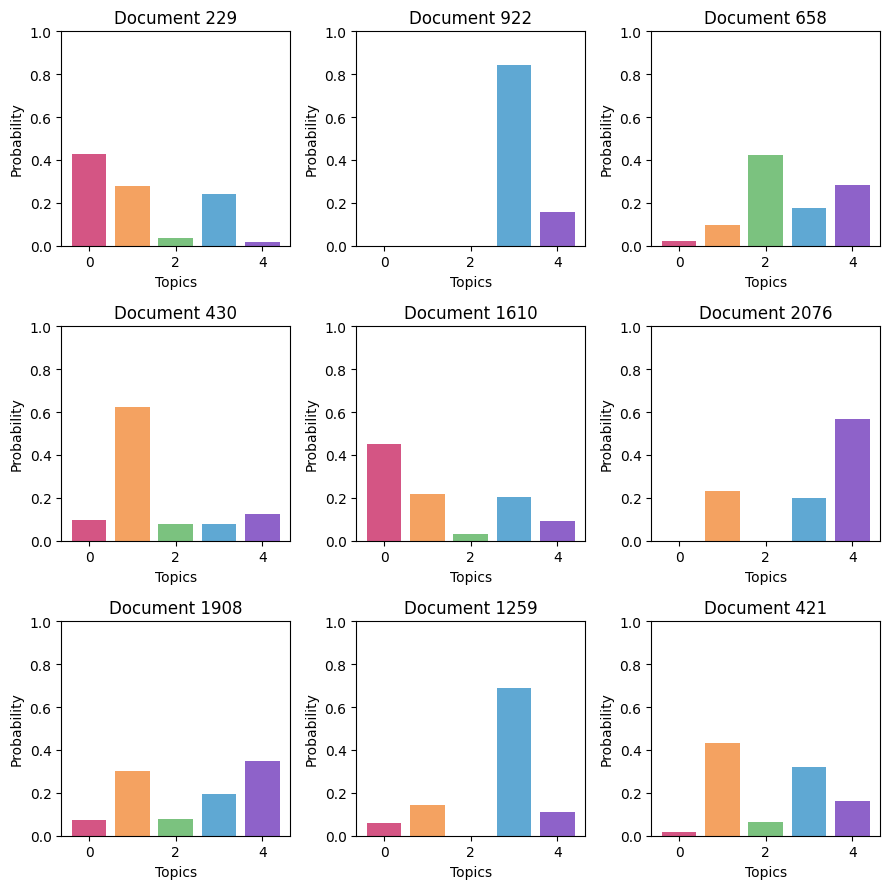

In [ ]:
np.random.seed(2025)

doc_list = np.random.randint(0, len(data), 15)

doc_list = np.random.randint(0, len(data), 9)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for m, theta in enumerate([probabilities[i] for i in doc_list]):
    row = m // 3
    col = m % 3
    axs[row, col].bar(range(len(theta)), theta, color=[topic_colors[j % len(topic_colors)] for j in range(len(theta))])
    axs[row, col].set_title(f'Document {doc_list[m]+1}')
    axs[row, col].set_xlabel('Topics')
    axs[row, col].set_ylabel('Probability')
    axs[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 3) Document Visualization

In [ ]:
doc_list = [156, 800, 1059, 1500, 2000]

for doc in doc_list:
    doc_html = document_visualizaion(model, data, doc-1, 1)
    display(HTML(f"<html><body>{doc_html}</body></html>"))

# Evaluation Metrics
- Accuracy
- TC (Topic Coherence)
- ARI (Adjusted Rand Index)
- NMI (Normalized Mutual Information)

In [ ]:
pred_topic = topics
true_topic = news_data['category']

count_matrix = pd.crosstab(pred_topic, true_topic)
count_matrix

category,business,entertainment,politics,sport,tech
row_0,,,,,
0,7,2,3,510,3
1,460,4,1,0,6
2,1,367,1,0,3
3,26,3,408,1,2
4,16,10,4,0,387


In [ ]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# Assignment pseudo-label
cost = - count_matrix.values

# Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(cost)

# mapping: pred_topic(row) → true_topic(col)
mapping = {int(row): count_matrix.columns[int(col)] for row, col in zip(row_ind, col_ind)}
mapped_pred_topic = np.array([mapping[p] for p in pred_topic])

# accuracy
accuracy = np.mean(mapped_pred_topic == true_topic)
print(f"Accuracy: {accuracy:.3f}")


# ARI
ari = adjusted_rand_score(true_topic, mapped_pred_topic)
print(f"ARI Score: {ari:.3f}")


# NMI
nmi = normalized_mutual_info_score(true_topic, mapped_pred_topic)
print(f"NMI Score: {nmi:.3f}")

Accuracy: 0.958
ARI Score: 0.899
NMI Score: 0.872
